# 导入数据集和模组

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 数据预处理

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'

# 加载数据集
df = pd.read_excel('RR_simul_data.xlsx')

# 定义一个函数来转换序列列，并对其进行标准化
def process_sequence_column(series, scaler=None):
    # 将字符串表示的列表转换为实际的列表
    series = series.apply(lambda x: eval(x) if isinstance(x, str) else x)
    # 标准化序列中的每个元素
    series = series.apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten() if scaler else x)
    return series

# 实例化scaler
scaler = StandardScaler()

# 对序列型特征进行处理
df['arrival_rate'] = process_sequence_column(df['arrival_rate'], scaler)
df['CV_list'] = process_sequence_column(df['CV_list'], scaler)
df['C_list'] = process_sequence_column(df['C_list'], scaler)

# 处理数值型特征: 使用标准化
numeric_features = df[['n', 'service_rate', 'm']]
scaler_numeric = StandardScaler()
numeric_features_scaled = scaler_numeric.fit_transform(numeric_features)

# 对ksai进行One-Hot编码
encoder = OneHotEncoder(sparse=False)
ksai_encoded = encoder.fit_transform(df[['ksai']])

# 将编码后的ksai合并到数值特征中
numeric_features_scaled = np.concatenate([numeric_features_scaled, ksai_encoded], axis=1)

# 对 avg_wait_time 目标变量进行标准化
scaler_time = StandardScaler()
scaler_targets = StandardScaler()
df['avg_wait_time'] = scaler_time.fit_transform(df[['avg_wait_time']])
# 使用 avg_pkg_loss_rate 的原始数据
# 不需要对 avg_pkg_loss_rate 进行标准化

# 对序列型目标变量进行标准化
def standardize_sequence_list(sequence_list, scaler):
    standardized_list = []
    for sequence in sequence_list:
        # 将字符串表示的列表转换为实际的列表
        sequence = eval(sequence) if isinstance(sequence, str) else sequence
        # 将列表转换为NumPy数组并进行标准化
        standardized_sequence = scaler.fit_transform(np.array(sequence).reshape(-1, 1)).flatten()
        standardized_list.append(standardized_sequence)
    return standardized_list

# 应用标准化函数到序列型目标变量
standardized_queue_waiting_length_list = standardize_sequence_list(df['queue_waiting_length_list'], scaler_targets)

# 准备模型的输入和目标变量
X_numeric = numeric_features_scaled
y_wait_time = df['avg_wait_time'].values
y_pkg_loss_rate = df['avg_pkg_loss_rate'].values
y_queue_waiting_length = np.array(df['queue_waiting_length_list'].tolist())

# 拆分训练集和测试集
train_indices, test_indices = train_test_split(range(len(df)), test_size=0.2, random_state=42)

# 提取训练集和测试集的数值型特征
X_train_numeric = X_numeric[train_indices]
X_test_numeric = X_numeric[test_indices]

# 提取训练集和测试集的序列型特征
X_train_sequences = {
    'arrival_rate': [df['arrival_rate'].iloc[i] for i in train_indices],
    'CV_list': [df['CV_list'].iloc[i] for i in train_indices],
    'C_list': [df['C_list'].iloc[i] for i in train_indices]
}

X_test_sequences = {
    'arrival_rate': [df['arrival_rate'].iloc[i] for i in test_indices],
    'CV_list': [df['CV_list'].iloc[i] for i in test_indices],
    'C_list': [df['C_list'].iloc[i] for i in test_indices]
}

# 提取训练集和测试集的目标变量
y_train_wait = y_wait_time[train_indices]
y_test_wait = y_wait_time[test_indices]
y_train_pkg_loss = df.loc[train_indices, 'avg_pkg_loss_rate'].values
y_test_pkg_loss = df.loc[test_indices, 'avg_pkg_loss_rate'].values
y_train_queue = [standardized_queue_waiting_length_list[i] for i in train_indices]
y_test_queue = [standardized_queue_waiting_length_list[i] for i in test_indices]

# 提取训练集和测试集的序列长度
sequence_lengths_train = df.loc[train_indices, 'n'].values
sequence_lengths_test = df.loc[test_indices, 'n'].values

# 模型（跑不通

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.optim import Adam
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

def collate_fn(batch):
    # 按序列长度降序排序
    batch.sort(key=lambda x: x[4], reverse=True)  # x[4] 是序列长度，参考__getitem__的输出
    # 解包批次数据
    numeric_features, arrival_rate, CV_list, C_list, seq_lengths, targets_wait, targets_pkg_loss, targets_queue = zip(*batch)
    
    # 获取最大序列长度
    max_length = max(seq_lengths)
    
    # 填充序列，并在必要时截断到最大长度
    padded_arrival_rate = pad_sequence([torch.tensor(ar[:max_length], dtype=torch.float) for ar in arrival_rate], batch_first=True, padding_value=0.0)
    padded_CV_list = pad_sequence([torch.tensor(cv[:max_length], dtype=torch.float) for cv in CV_list], batch_first=True, padding_value=0.0)
    padded_C_list = pad_sequence([torch.tensor(c[:max_length], dtype=torch.float) for c in C_list], batch_first=True, padding_value=0.0)
    
    # 转换为张量
    numeric_features = torch.stack([torch.tensor(n, dtype=torch.float) for n in numeric_features])
    seq_lengths = torch.tensor(seq_lengths, dtype=torch.long)
    targets_wait = torch.tensor(targets_wait, dtype=torch.float)
    targets_pkg_loss = torch.tensor(targets_pkg_loss, dtype=torch.float)
    
    # 对于序列型目标变量，我们需要保留其原始长度的列表
    targets_queue = [torch.tensor(tq, dtype=torch.float) for tq in targets_queue]  # 转换为张量列表
    
    # 将所有序列数据合并为一个张量
    sequence_data = torch.cat((padded_arrival_rate.unsqueeze(1), padded_CV_list.unsqueeze(1), padded_C_list.unsqueeze(1)), dim=1)
    
    return numeric_features, sequence_data, seq_lengths, targets_wait, targets_pkg_loss, targets_queue

def sequence_loss(output, target, length):
    loss = 0.0
    for i in range(len(output)):
        # 只计算到每个序列实际长度的损失
        loss += criterion(output[i, :length[i]], target[i, :length[i]])
    return loss / len(output)

# 定义自定义的Dataset类来处理可变长度的序列数据和多个目标变量
class VariableLengthDataset(Dataset):
    def __init__(self, numeric_features, arrival_rate, CV_list, C_list, sequences_lengths, target_wait, target_pkg_loss, target_queue_length):
        self.numeric_features = numeric_features
        self.arrival_rate = arrival_rate
        self.CV_list = CV_list
        self.C_list = C_list
        self.sequences_lengths = sequences_lengths
        self.target_wait = target_wait
        self.target_pkg_loss = target_pkg_loss
        self.target_queue_length = target_queue_length

    def __len__(self):
        return len(self.target_wait)

    def __getitem__(self, idx):
        return (self.numeric_features[idx],
                self.arrival_rate[idx],
                self.CV_list[idx],
                self.C_list[idx],
                self.sequences_lengths[idx],
                self.target_wait[idx],
                self.target_pkg_loss[idx],
                self.target_queue_length[idx])

# 创建训练数据的 DataLoader
train_dataset = VariableLengthDataset(
    X_train_numeric,
    X_train_sequences['arrival_rate'],
    X_train_sequences['CV_list'],
    X_train_sequences['C_list'],
    sequence_lengths_train,
    y_train_wait,
    y_train_pkg_loss,
    y_train_queue  # 这是输出序列目标
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 创建测试数据的 DataLoader
test_dataset = VariableLengthDataset(
    X_test_numeric,
    X_test_sequences['arrival_rate'],
    X_test_sequences['CV_list'],
    X_test_sequences['C_list'],
    sequence_lengths_test,
    y_test_wait,
    y_test_pkg_loss,
    y_test_queue  # 这是输出序列目标
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 创建DataLoader时使用collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, numeric_input_size, sequence_input_size, hidden_size, output_size_wait, output_size_pkg_loss, output_size_queue):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(sequence_input_size, hidden_size, batch_first=True)
        self.fc_numeric = nn.Linear(numeric_input_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out_wait = nn.Linear(hidden_size, output_size_wait)
        self.fc_out_pkg_loss = nn.Linear(hidden_size, output_size_pkg_loss)
        self.fc_out_queue = nn.Linear(hidden_size, output_size_queue)
    
    def forward(self, numeric_input, sequence_input, sequence_lengths):
        # 处理数值输入
        numeric_output = torch.relu(self.fc_numeric(numeric_input))
        
        # 处理序列输入
        packed_input = pack_padded_sequence(sequence_input, sequence_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        sequence_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # 合并数值输入和序列输入
        combined_input = torch.cat((numeric_output, sequence_output), dim=2)
        combined_output = torch.relu(self.fc_combined(combined_input))

        # 输出层
        output_wait = self.fc_out_wait(combined_output)
        output_pkg_loss = self.fc_out_pkg_loss(combined_output)
        output_queue = self.fc_out_queue(combined_output)
        return output_wait, output_pkg_loss, output_queue


# 实例化模型时，确保传入正确的参数
model = RNNModel(numeric_input_size=X_train_numeric.shape[1],
                 sequence_input_size=20,  # 假设序列特征有20个变量
                 hidden_size=64,
                 output_size_wait=1,      # 输出层大小，针对 targets_wait
                 output_size_pkg_loss=1,  # 输出层大小，针对 targets_pkg_loss
                 output_size_queue=1)     # 输出层大小，针对 targets_queue

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# 训练模型并记录历史
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=200):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            numeric_input, sequence_input, sequence_lengths, targets_wait, targets_pkg_loss, targets_queue = data
            optimizer.zero_grad()
            
            # 前向传播
            outputs_wait, outputs_pkg_loss, outputs_queue = model(numeric_input, sequence_input, sequence_lengths)
            # 计算损失
            loss_wait = criterion(outputs_wait, targets_wait)
            loss_pkg_loss = criterion(outputs_pkg_loss, targets_pkg_loss)
            
            # 对于可变长度的序列目标，我们需要特别处理
            loss_queue = 0
            for i in range(len(outputs_queue)):
                # 注意这里我们不再使用 pack_padded_sequence
                output = outputs_queue[i, :sequence_lengths[i]]
                target = targets_queue[i][:sequence_lengths[i]]
                loss_queue += criterion(output, target)
            loss_queue /= len(outputs_queue)
            
            # 合并损失
            loss = loss_wait + loss_pkg_loss + loss_queue
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # 计算平均训练损失
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # 在每个epoch后进行验证
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for numeric_input, sequence_input, sequence_lengths, targets in test_loader:
                # 转换序列输入为张量并排序
                sequence_input = torch.nn.utils.rnn.pad_sequence([torch.tensor(s) for s in sequence_input], batch_first=True)
                sequence_lengths = torch.tensor(sequence_lengths)
                # 转换数值输入和目标为张量
                numeric_input = torch.tensor(numeric_input, dtype=torch.float32)
                targets = torch.tensor(targets, dtype=torch.float32)
                # 前向传播
                outputs = model(numeric_input, sequence_input, sequence_lengths)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        # 计算平均验证损失
        avg_val_loss = val_loss / len(test_loader)
        history['val_loss'].append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')
    
    return history

# 使用训练和验证数据加载器调用 train_model 函数
history = train_model(model, train_loader, test_loader, optimizer, criterion)

# 保存模型
torch.save(model.state_dict(), 'rnn_model.pth')

# 定义评估函数
def evaluate_model(model, test_loader, criterion):
    model.eval()  # 设置模型为评估模式
    total_loss = 0
    with torch.no_grad():  # 在评估过程中不计算梯度
        for numeric_input, sequence_input, sequence_lengths, targets_wait, targets_pkg_loss, targets_queue in test_loader:
            # 转换序列输入为张量并排序
            sequence_input = torch.nn.utils.rnn.pad_sequence([torch.tensor(s) for s in sequence_input], batch_first=True)
            sequence_lengths = torch.tensor(sequence_lengths)
            # 转换数值输入和目标为张量
            numeric_input = torch.tensor(numeric_input, dtype=torch.float32)
            # 前向传播
            outputs_wait, outputs_pkg_loss, outputs_queue = model(numeric_input, sequence_input, sequence_lengths)
            # 计算损失
            loss_wait = criterion(outputs_wait, targets_wait)
            loss_pkg_loss = criterion(outputs_pkg_loss, targets_pkg_loss)
            # 对于可变长度的序列目标，我们需要特别处理
            loss_queue = 0
            for i in range(len(outputs_queue)):
                output = outputs_queue[i, :sequence_lengths[i]]
                target = targets_queue[i][:sequence_lengths[i]]
                loss_queue += criterion(output, target)
            loss_queue /= len(outputs_queue)
            # 合并损失
            loss = loss_wait + loss_pkg_loss + loss_queue
            total_loss += loss.item()
    return total_loss / len(test_loader)

# 创建测试数据的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# 评估模型
test_loss = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}")

# 绘制训练损失和验证损失
# 假设我们在训练过程中保存了损失历史
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ver2（也跑不通

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# 定义collate_fn函数，用于处理可变长度的序列数据
def collate_fn(batch):
    # 按序列长度降序排序
    batch.sort(key=lambda x: len(x[1]), reverse=True)  # 假设x[1]是arrival_rate，其长度代表序列长度
    # 解包批次数据
    numeric_features, arrival_rate, CV_list, C_list, targets_wait, targets_pkg_loss, targets_queue = zip(*batch)
    
    # 填充序列
    padded_arrival_rate = pad_sequence([torch.tensor(ar) for ar in arrival_rate], batch_first=True)
    padded_CV_list = pad_sequence([torch.tensor(cv) for cv in CV_list], batch_first=True)
    padded_C_list = pad_sequence([torch.tensor(c) for c in C_list], batch_first=True)
    
    # 获取序列长度
    seq_lengths = torch.tensor([len(ar) for ar in arrival_rate])
    
    # 转换其他数据为张量
    targets_wait = torch.tensor(targets_wait, dtype=torch.float)
    targets_pkg_loss = torch.tensor(targets_pkg_loss, dtype=torch.float)
    targets_queue = pad_sequence([torch.tensor(tq) for tq in targets_queue], batch_first=True)
    
    # 合并序列数据
    sequence_data = torch.cat((padded_arrival_rate.unsqueeze(-1), padded_CV_list.unsqueeze(-1), padded_C_list.unsqueeze(-1)), dim=2)
    
    # 返回一个包含所有特征的元组，其中numeric_features是一个列表
    return numeric_features, sequence_data, seq_lengths, targets_wait, targets_pkg_loss, targets_queue

# 定义自定义的Dataset类
class VariableLengthDataset(Dataset):
    def __init__(self, numeric_features, arrival_rate, CV_list, C_list, target_wait, target_pkg_loss, target_queue_length):
        self.numeric_features = numeric_features
        self.arrival_rate = arrival_rate
        self.CV_list = CV_list
        self.C_list = C_list
        self.target_wait = target_wait
        self.target_pkg_loss = target_pkg_loss
        self.target_queue_length = target_queue_length

    def __len__(self):
        return len(self.target_wait)

    def __getitem__(self, idx):
        return (self.numeric_features[idx],
                self.arrival_rate[idx],
                self.CV_list[idx],
                self.C_list[idx],
                self.target_wait[idx],
                self.target_pkg_loss[idx],
                self.target_queue_length[idx])

# 假设以下变量已经被正确赋值
# X_train_numeric, X_train_sequences, sequence_lengths_train, y_train_wait, y_train_pkg_loss, y_train_queue
# X_test_numeric, X_test_sequences, sequence_lengths_test, y_test_wait, y_test_pkg_loss, y_test_queue

# 创建训练数据的 DataLoader
train_dataset = VariableLengthDataset(
    X_train_numeric,
    X_train_sequences['arrival_rate'],
    X_train_sequences['CV_list'],
    X_train_sequences['C_list'],
    y_train_wait,
    y_train_pkg_loss,
    y_train_queue  # 这是输出序列目标
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 创建测试数据的 DataLoader
test_dataset = VariableLengthDataset(
    X_test_numeric,
    X_test_sequences['arrival_rate'],
    X_test_sequences['CV_list'],
    X_test_sequences['C_list'],
    y_test_wait,
    y_test_pkg_loss,
    y_test_queue  # 这是输出序列目标
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, numeric_input_size, sequence_input_size, hidden_size, output_size_wait, output_size_pkg_loss, output_size_queue):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(sequence_input_size, hidden_size, batch_first=True)
        self.fc_numeric = nn.Linear(numeric_input_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out_wait = nn.Linear(hidden_size, output_size_wait)
        self.fc_out_pkg_loss = nn.Linear(hidden_size, output_size_pkg_loss)
        self.fc_out_queue = nn.Linear(hidden_size, output_size_queue)
    
    def forward(self, numeric_input, sequence_input, sequence_lengths):
        # 处理数值输入
        numeric_output = torch.relu(self.fc_numeric(numeric_input))
        
        # 处理序列输入
        packed_input = pack_padded_sequence(sequence_input, sequence_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        sequence_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # 合并数值输入和序列输入
        combined_input = torch.cat((numeric_output, sequence_output), dim=2)
        combined_output = torch.relu(self.fc_combined(combined_input))

        # 输出层
        output_wait = self.fc_out_wait(combined_output)
        output_pkg_loss = self.fc_out_pkg_loss(combined_output)
        output_queue = self.fc_out_queue(combined_output)
        return output_wait, output_pkg_loss, output_queue

# 实例化模型时，确保传入正确的参数
model = RNNModel(numeric_input_size=X_train_numeric.shape[1],
                 sequence_input_size=20,  # 假设序列特征有20个变量
                 hidden_size=64,
                 output_size_wait=1,      # 输出层大小，针对 targets_wait
                 output_size_pkg_loss=1,  # 输出层大小，针对 targets_pkg_loss
                 output_size_queue=1)     # 输出层大小，针对 targets_queue

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# 训练模型的函数
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=200):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            numeric_input, sequence_input, sequence_lengths, targets_wait, targets_pkg_loss, targets_queue = data
            optimizer.zero_grad()
            
            # 前向传播
            outputs_wait, outputs_pkg_loss, outputs_queue = model(numeric_input, sequence_input, sequence_lengths)
            # 计算损失
            loss_wait = criterion(outputs_wait.squeeze(), targets_wait)
            loss_pkg_loss = criterion(outputs_pkg_loss.squeeze(), targets_pkg_loss)
            loss_queue = sequence_loss(outputs_queue, targets_queue, sequence_lengths)
            
            # 合并损失
            loss = loss_wait + loss_pkg_loss + loss_queue
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # 计算平均训练损失
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # 在每个epoch后进行验证
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                numeric_input, sequence_input, sequence_lengths, targets_wait, targets_pkg_loss, targets_queue = data
                
                # 前向传播
                outputs_wait, outputs_pkg_loss, outputs_queue = model(numeric_input, sequence_input, sequence_lengths)
                # 计算损失
                loss_wait = criterion(outputs_wait.squeeze(), targets_wait)
                loss_pkg_loss = criterion(outputs_pkg_loss.squeeze(), targets_pkg_loss)
                loss_queue = sequence_loss(outputs_queue, targets_queue, sequence_lengths)
                
                # 合并损失
                loss = loss_wait + loss_pkg_loss + loss_queue
                val_loss += loss.item()
        # 计算平均验证损失
        avg_val_loss = val_loss / len(test_loader)
        history['val_loss'].append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')
    
    return history

# 使用训练和验证数据加载器调用 train_model 函数
history = train_model(model, train_loader, test_loader, optimizer, criterion)

# 保存模型
torch.save(model.state_dict(), 'rnn_model.pth')

# 定义评估函数
def evaluate_model(model, test_loader, criterion):
    model.eval()  # 设置模型为评估模式
    total_loss = 0
    with torch.no_grad():  # 在评估过程中不计算梯度
        for data in test_loader:
            numeric_input, sequence_input, sequence_lengths, targets_wait, targets_pkg_loss, targets_queue = data
            
            # 前向传播
            outputs_wait, outputs_pkg_loss, outputs_queue = model(numeric_input, sequence_input, sequence_lengths)
            # 计算损失
            loss_wait = criterion(outputs_wait.squeeze(), targets_wait)
            loss_pkg_loss = criterion(outputs_pkg_loss.squeeze(), targets_pkg_loss)
            loss_queue = sequence_loss(outputs_queue, targets_queue, sequence_lengths)
            
            # 合并损失
            loss = loss_wait + loss_pkg_loss + loss_queue
            total_loss += loss.item()
    return total_loss / len(test_loader)

# 评估模型
test_loss = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}")

# 绘制训练损失和验证损失
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

# 返璞归真

## 1. RNN

### 1.1 Simple RNN（同时输出数值型变量和序列型变量）

In [3]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    SimpleRNN,
    Dense,
    TimeDistributed,
    concatenate,
    Masking,
    RepeatVector,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
inputs = {}
for feature_name, feature_shape in zip(
    ["arrival_rate", "CV_list", "C_list"], [(sequence_input_length, 1)] * 3
):
    inputs[feature_name] = Input(shape=feature_shape, name=f"{feature_name}_input")
inputs["numeric_input"] = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# RNN层
rnn_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    rnn_layers[feature_name] = SimpleRNN(hidden_units, return_sequences=True)(
        input_layer
    )

# 扩展numeric_input的形状以匹配RNN层的输出形状
numeric_input_expanded = RepeatVector(sequence_input_length)(inputs["numeric_input"])

# 合并所有输入
merged = concatenate(list(rnn_layers.values()) + [numeric_input_expanded])

# 定义输出层
outputs = {}
for output_name, output_shape in zip(
    ["wait_time_output", "pkg_loss_rate_output", "queue_waiting_length_output"],
    [(1,)] * 3,
):
    if output_name == "queue_waiting_length_output":
        outputs[output_name] = TimeDistributed(
            Dense(output_shape[-1]), name=output_name
        )(merged)
    else:
        outputs[output_name] = Dense(output_shape[-1], name=output_name)(merged)

# 填充训练集和测试集的序列型特征
max_sequence_length = max(df["n"])
X_train_padded_sequences = {}
X_test_padded_sequences = {}
for feature_name, feature_sequences in X_train_sequences.items():
    padded_sequences = pad_sequences(
        feature_sequences, maxlen=max_sequence_length, padding="post", dtype="float32"
    )
    X_train_padded_sequences[feature_name] = padded_sequences
    X_test_padded_sequences[feature_name] = pad_sequences(
        X_test_sequences[feature_name],
        maxlen=max_sequence_length,
        padding="post",
        dtype="float32",
    )

# 填充训练集和测试集的序列型目标变量
y_train_queue_padded = pad_sequences(
    y_train_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)
y_test_queue_padded = pad_sequences(
    y_test_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)

# 更新模型定义以包含Masking层
masked_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    masking_layer = Masking(mask_value=0.0)  # 假设填充值为0
    masked_layers[feature_name] = masking_layer(input_layer)

# RNN层
rnn_layers = {}
for feature_name, masked_layer in masked_layers.items():
    rnn_layers[feature_name] = SimpleRNN(hidden_units, return_sequences=True)(
        masked_layer
    )

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse",
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae",
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_1_1.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(history.history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 3, 2)
plt.plot(history.history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 queue_waiting_length_list 的训练损失和验证损失
plt.subplot(1, 3, 3)
plt.plot(
    history.history["queue_waiting_length_output_loss"],
    label="训练集上的损失",
)
plt.plot(
    history.history["val_queue_waiting_length_output_loss"],
    label="测试集上的损失",
)
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/1.1.png", dpi=1200)
plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 numeric_input (InputLayer)  [(None, 8)]                  0         []                        

KeyboardInterrupt: 

### 1.2 Simple RNN（只考虑输出数值型变量）

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_56 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

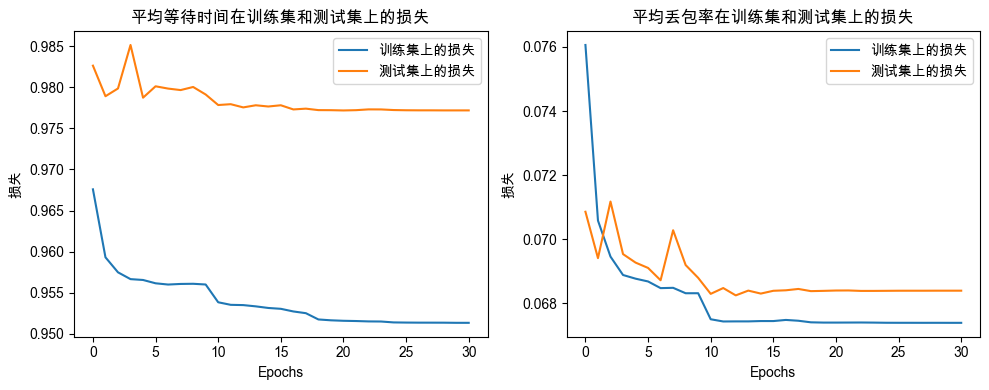

In [186]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list_input")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN
encoder_rnn = SimpleRNN(hidden_units, return_sequences=False, return_state=True)
encoder_outputs, state_h = encoder_rnn(
    concatenate([arrival_rate_input, CV_list_input, C_list_input])
)

# 数值型输出层
wait_time_output = Dense(1, name="wait_time_output")(state_h)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(state_h)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={"wait_time_output": "mse", "pkg_loss_rate_output": "mse"},
    metrics={"wait_time_output": "mae", "pkg_loss_rate_output": "mae"},
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_1_2.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 解包 eval_results
total_loss, wait_time_loss, pkg_loss_rate_loss, wait_time_mae, pkg_loss_rate_mae = (
    eval_results
)

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_wait_time_output_loss"], label="测试集上的损失"
)
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(
    history.history["pkg_loss_rate_output_loss"], label="训练集上的损失"
)
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/1.2.png", dpi=1200)
plt.show()

### 1.3 Seq2Seq - Simple RNN（只考虑序列型变量，即waiting_length）

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_57 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

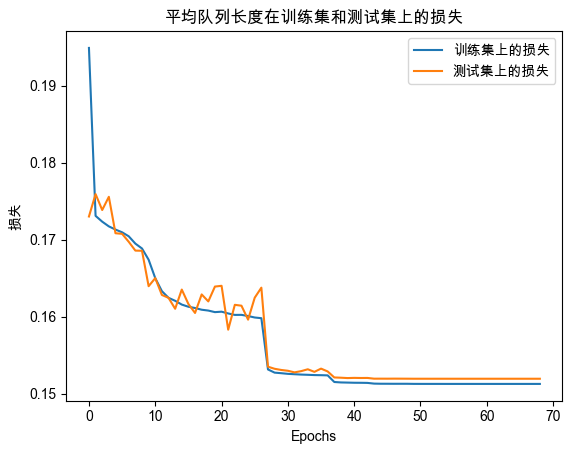

In [187]:
from tensorflow.keras.layers import (
    Input,
    SimpleRNN,
    Dense,
    RepeatVector,
    TimeDistributed,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
# 序列型输入
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")

# 数值型和分类型输入
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器
# 可以选择将所有序列型输入合并，或者只选择一个作为主要序列输入
encoder_inputs = concatenate([arrival_rate_input, CV_list_input, C_list_input])
encoder_rnn = SimpleRNN(hidden_units, return_state=True)
encoder_outputs, state_h = encoder_rnn(encoder_inputs)

# 解码器
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)

# 将数值型和分类型输入与解码器输出合并
decoder_outputs = concatenate(
    [decoder_outputs, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_outputs)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_1_3.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/1.3.png", dpi=1200)
plt.show()

### 1.4 Seq2Seq - Simple RNN + 注意力机制（BA）（只考虑序列型变量，即waiting_length）

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_59 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

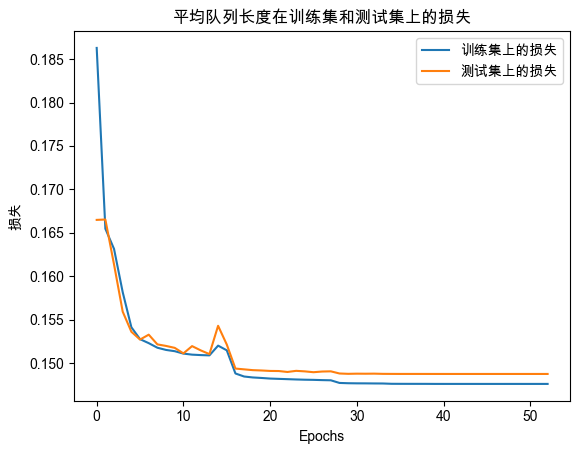

In [188]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, RepeatVector, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN，返回整个序列
encoder_rnn = SimpleRNN(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder_rnn(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 RNN，返回整个序列
decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)

# 注意力机制
attention = Attention()
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 输出层
decoder_dense = TimeDistributed(Dense(1))  # 假设输出是单变量序列
decoder_outputs = decoder_dense(decoder_combined_context)

# 将数值型和分类型输入与解码器输出合并
decoder_combined_context = concatenate(
    [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_combined_context)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_1_4.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/1.4.png", dpi=1200)
plt.show()

### 1.5 Seq2Seq - Simple RNN + 注意力机制（LA）（只考虑序列型变量，即waiting_length）

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_62 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

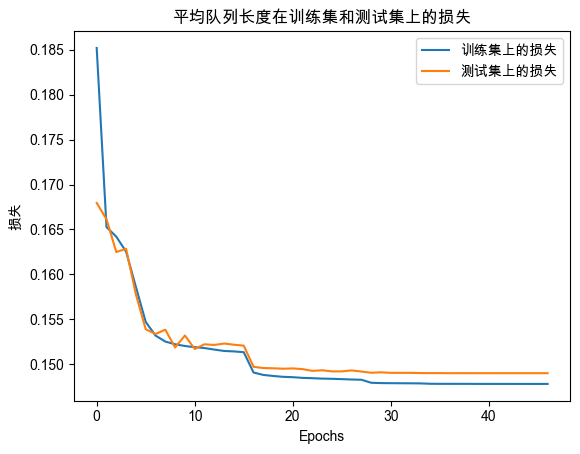

In [189]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, RepeatVector, TimeDistributed, Attention, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN，返回整个序列
encoder_rnn = SimpleRNN(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder_rnn(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 RNN，返回整个序列
decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)

# Luong 注意力机制
attention = Attention(use_scale=True)
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 输出层
decoder_dense = TimeDistributed(Dense(1))  # 假设输出是单变量序列
decoder_outputs = decoder_dense(decoder_combined_context)

# 将数值型和分类型输入与解码器输出合并
decoder_combined_context = concatenate(
    [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_combined_context)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_1_5.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/1.5.png", dpi=1200)
plt.show()

## 2. LSTM

### 2.1 LSTM（同时输出数值型变量和序列型变量）

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 masking_18 (Masking)        (None, 20, 1)                0         ['arrival_rate_input[0]

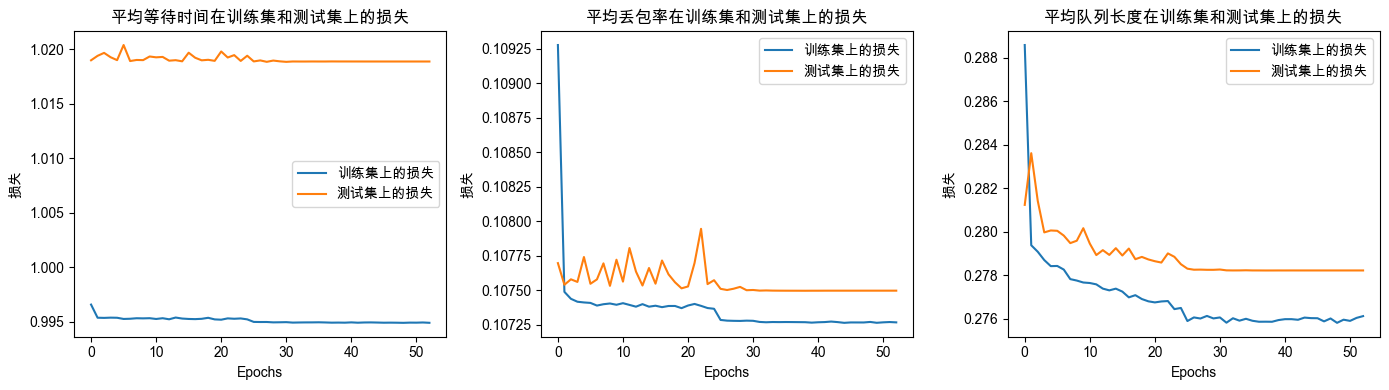

In [190]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    TimeDistributed,
    concatenate,
    Masking,
    RepeatVector,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
inputs = {}
for feature_name, feature_shape in zip(
    ["arrival_rate", "CV_list", "C_list"], [(sequence_input_length, 1)] * 3
):
    inputs[feature_name] = Input(shape=feature_shape, name=f"{feature_name}_input")
inputs["numeric_input"] = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# Masking层
masked_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    masked_layers[feature_name] = Masking(mask_value=0.0)(input_layer)  # 假设填充值为0

# LSTM层
lstm_layers = {}
for feature_name, masked_layer in masked_layers.items():
    lstm_layers[feature_name] = LSTM(hidden_units, return_sequences=True)(masked_layer)

# 扩展numeric_input的形状以匹配LSTM层的输出形状
numeric_input_expanded = RepeatVector(sequence_input_length)(inputs["numeric_input"])

# 合并所有输入
merged = concatenate(list(lstm_layers.values()) + [numeric_input_expanded])

# 定义输出层
outputs = {}
for output_name, output_shape in zip(
    ["wait_time_output", "pkg_loss_rate_output", "queue_waiting_length_output"],
    [(1,)] * 3,
):
    if output_name == "queue_waiting_length_output":
        outputs[output_name] = TimeDistributed(
            Dense(output_shape[-1]), name=output_name
        )(merged)
    else:
        outputs[output_name] = Dense(output_shape[-1], name=output_name)(merged)

# 填充训练集和测试集的序列型特征
max_sequence_length = max(df["n"])
X_train_padded_sequences = {}
X_test_padded_sequences = {}
for feature_name, feature_sequences in X_train_sequences.items():
    padded_sequences = pad_sequences(
        feature_sequences, maxlen=max_sequence_length, padding="post", dtype="float32"
    )
    X_train_padded_sequences[feature_name] = padded_sequences
    X_test_padded_sequences[feature_name] = pad_sequences(
        X_test_sequences[feature_name],
        maxlen=max_sequence_length,
        padding="post",
        dtype="float32",
    )

# 填充训练集和测试集的序列型目标变量
y_train_queue_padded = pad_sequences(
    y_train_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)
y_test_queue_padded = pad_sequences(
    y_test_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse",
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae",
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_2_1.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

y_train_queue_padded = np.expand_dims(
    y_train_queue_padded, -1
)  # 在最后一个轴上增加一个维度
y_test_queue_padded = np.expand_dims(
    y_test_queue_padded, -1
)  # 在最后一个轴上增加一个维度

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(history.history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 3, 2)
plt.plot(history.history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 queue_waiting_length_list 的训练损失和验证损失
plt.subplot(1, 3, 3)
plt.plot(
    history.history["queue_waiting_length_output_loss"],
    label="训练集上的损失",
)
plt.plot(
    history.history["val_queue_waiting_length_output_loss"],
    label="测试集上的损失",
)
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/2.1.png", dpi=1200)
plt.show()

### 2.2 LSTM（只考虑输出数值型变量）

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_98 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

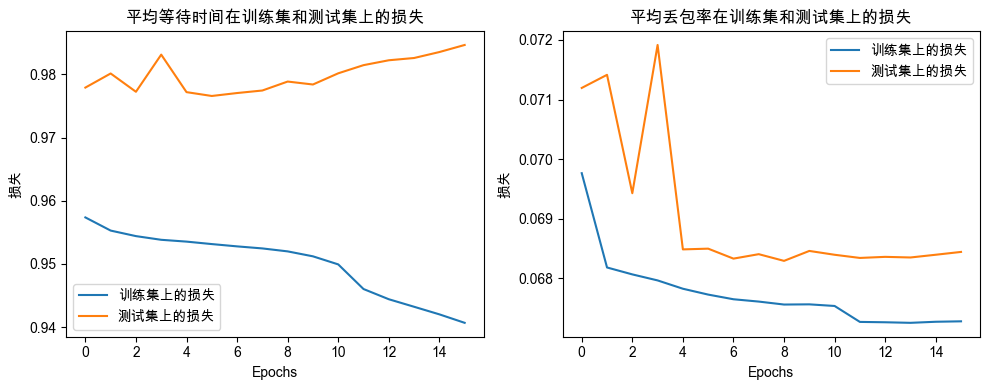

In [235]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list_input")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 LSTM
encoder_lstm = LSTM(hidden_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(
    concatenate([arrival_rate_input, CV_list_input, C_list_input])
)

# 数值型输出层
wait_time_output = Dense(1, name="wait_time_output")(state_h)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(state_h)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={"wait_time_output": "mse", "pkg_loss_rate_output": "mse"},
    metrics={"wait_time_output": "mae", "pkg_loss_rate_output": "mae"},
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_2_2.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 解包 eval_results
total_loss, wait_time_loss, pkg_loss_rate_loss, wait_time_mae, pkg_loss_rate_mae = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_wait_time_output_loss"], label="测试集上的损失"
)
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(
    history.history["pkg_loss_rate_output_loss"], label="训练集上的损失"
)
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/2.2.png", dpi=1200)
plt.show()

### 2.3 Seq2Seq - LSTM（只考虑序列型变量，即waiting_length）

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_67 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

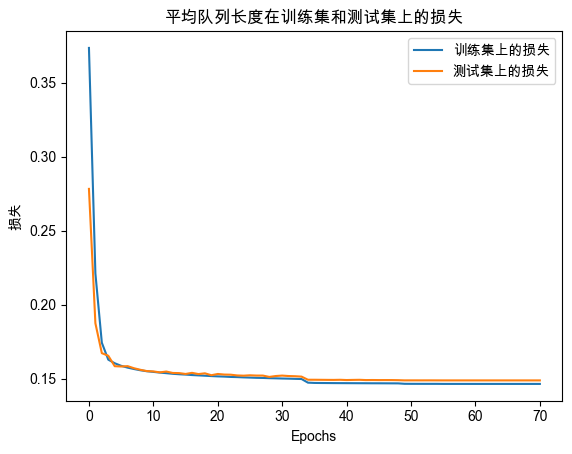

In [192]:
from tensorflow.keras.layers import (
    Input,
    LSTM,  # Import LSTM instead of SimpleRNN
    Dense,
    RepeatVector,
    TimeDistributed,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
# 序列型输入
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")

# 数值型和分类型输入
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器
# 可以选择将所有序列型输入合并，或者只选择一个作为主要序列输入
encoder_inputs = concatenate([arrival_rate_input, CV_list_input, C_list_input])
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(
    encoder_inputs
)  # LSTM returns cell state as well

# 解码器
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_lstm = LSTM(hidden_units, return_sequences=True)
decoder_outputs = decoder_lstm(
    decoder_inputs, initial_state=[state_h, state_c]
)  # LSTM requires both states

# 将数值型和分类型输入与解码器输出合并
decoder_outputs = concatenate(
    [decoder_outputs, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_outputs)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_2_3.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/2.3.png", dpi=1200)
plt.show()

### 2.4 Seq2Seq - LSTM + 注意力机制（BA）（只考虑序列型变量，即waiting_length）

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_69 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

W0000 00:00:1707851982.638051       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6254/6259 [============================>.] - ETA: 0s - loss: 0.4013

W0000 00:00:1707852029.649034       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.29260, saving model to best_model_2_4.h5
6259/6259 [==============================] - 51s 8ms/step - loss: 0.4012 - val_loss: 0.2926 - lr: 0.0010
Epoch 2/200
6258/6259 [============================>.] - ETA: 0s - loss: 0.2359
Epoch 2: val_loss improved from 0.29260 to 0.19684, saving model to best_model_2_4.h5
6259/6259 [==============================] - 50s 8ms/step - loss: 0.2359 - val_loss: 0.1968 - lr: 0.0010
Epoch 3/200
6257/6259 [============================>.] - ETA: 0s - loss: 0.1771
Epoch 3: val_loss improved from 0.19684 to 0.16784, saving model to best_model_2_4.h5
6259/6259 [==============================] - 50s 8ms/step - loss: 0.1771 - val_loss: 0.1678 - lr: 0.0010
Epoch 4/200
6255/6259 [============================>.] - ETA: 0s - loss: 0.1631
Epoch 4: val_loss improved from 0.16784 to 0.16405, saving model to best_model_2_4.h5
6259/6259 [==============================] - 50s 8ms/step - loss: 0.1631 - val_loss: 0.1641 - lr: 0.0010

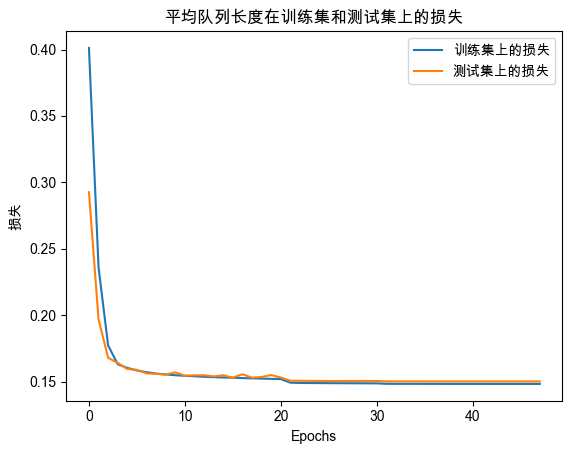

In [193]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 LSTM，返回整个序列和最后一个时间步的隐藏状态和单元状态
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 LSTM，返回整个序列
decoder_lstm = LSTM(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# 注意力机制
attention = Attention()
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 输出层
decoder_dense = TimeDistributed(Dense(1))  # 假设输出是单变量序列
decoder_outputs = decoder_dense(decoder_combined_context)

# 将数值型和分类型输入与解码器输出合并
decoder_combined_context = concatenate(
    [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_combined_context)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_2_4.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/2.4.png", dpi=1200)
plt.show()

### 2.5 Seq2Seq - LSTM + 注意力机制（LA）（只考虑序列型变量，即waiting_length）

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_72 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

W0000 00:00:1707854402.046519       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6256/6259 [============================>.] - ETA: 0s - loss: 0.3853

W0000 00:00:1707854449.363149       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.27674, saving model to best_model_2_5.h5
6259/6259 [==============================] - 52s 8ms/step - loss: 0.3853 - val_loss: 0.2767 - lr: 0.0010
Epoch 2/200
6255/6259 [============================>.] - ETA: 0s - loss: 0.2290
Epoch 2: val_loss improved from 0.27674 to 0.19661, saving model to best_model_2_5.h5
6259/6259 [==============================] - 50s 8ms/step - loss: 0.2290 - val_loss: 0.1966 - lr: 0.0010
Epoch 3/200
6258/6259 [============================>.] - ETA: 0s - loss: 0.1750
Epoch 3: val_loss improved from 0.19661 to 0.16280, saving model to best_model_2_5.h5
6259/6259 [==============================] - 50s 8ms/step - loss: 0.1750 - val_loss: 0.1628 - lr: 0.0010
Epoch 4/200
6253/6259 [============================>.] - ETA: 0s - loss: 0.1635
Epoch 4: val_loss improved from 0.16280 to 0.16093, saving model to best_model_2_5.h5
6259/6259 [==============================] - 51s 8ms/step - loss: 0.1635 - val_loss: 0.1609 - lr: 0.0010

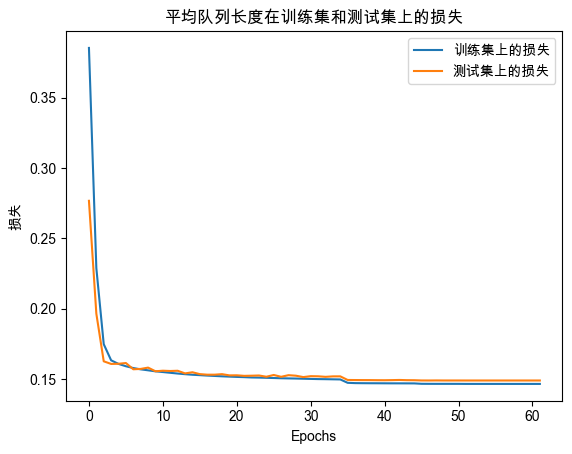

In [194]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 LSTM，返回整个序列和最后一个时间步的隐藏状态和单元状态
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 LSTM，返回整个序列
decoder_lstm = LSTM(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Luong 注意力机制
attention = Attention(use_scale=True)
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 输出层
decoder_dense = TimeDistributed(Dense(1))  # 假设输出是单变量序列
decoder_outputs = decoder_dense(decoder_combined_context)

# 将数值型和分类型输入与解码器输出合并
decoder_combined_context = concatenate(
    [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_combined_context)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_2_5.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/2.5.png", dpi=1200)
plt.show()

---

# 尝试下删除n=1数据的拟合结果（结果不好）

In [ ]:
# 加载数据集
df = pd.read_excel('RR_simul_data.xlsx')
df = df[df['n'] > 1].reset_index().iloc[:, 1:]

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 定义一个函数来转换序列列，并对其进行标准化
def process_sequence_column(series, scaler=None):
    # 将字符串表示的列表转换为实际的列表
    series = series.apply(lambda x: eval(x) if isinstance(x, str) else x)
    # 标准化序列中的每个元素
    series = series.apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten() if scaler else x)
    return series

# 实例化scaler
scaler = StandardScaler()

# 对序列型特征进行处理
df['arrival_rate'] = process_sequence_column(df['arrival_rate'], scaler)
df['CV_list'] = process_sequence_column(df['CV_list'], scaler)
df['C_list'] = process_sequence_column(df['C_list'], scaler)

# 处理数值型特征: 使用标准化
numeric_features = df[['n', 'service_rate', 'm']]
scaler_numeric = StandardScaler()
numeric_features_scaled = scaler_numeric.fit_transform(numeric_features)

# 对ksai进行One-Hot编码
encoder = OneHotEncoder(sparse=False)
ksai_encoded = encoder.fit_transform(df[['ksai']])

# 将编码后的ksai合并到数值特征中
numeric_features_scaled = np.concatenate([numeric_features_scaled, ksai_encoded], axis=1)

# 对目标变量进行标准化
scaler_targets = StandardScaler()
df['avg_wait_time'] = scaler_targets.fit_transform(df[['avg_wait_time']])
df['avg_pkg_loss_rate'] = scaler_targets.fit_transform(df[['avg_pkg_loss_rate']])

# 对序列型目标变量进行标准化
def standardize_sequence_list(sequence_list, scaler):
    standardized_list = []
    for sequence in sequence_list:
        # 将字符串表示的列表转换为实际的列表
        sequence = eval(sequence) if isinstance(sequence, str) else sequence
        # 将列表转换为NumPy数组并进行标准化
        standardized_sequence = scaler.fit_transform(np.array(sequence).reshape(-1, 1)).flatten()
        standardized_list.append(standardized_sequence)
    return standardized_list

# 应用标准化函数到序列型目标变量
standardized_queue_waiting_length_list = standardize_sequence_list(df['queue_waiting_length_list'], scaler_targets)

# 准备模型的输入和目标变量
X_numeric = numeric_features_scaled
y_wait_time = df['avg_wait_time'].values
y_pkg_loss_rate = df['avg_pkg_loss_rate'].values
y_queue_waiting_length = np.array(df['queue_waiting_length_list'].tolist())

# 拆分训练集和测试集
train_indices, test_indices = train_test_split(range(len(df)), test_size=0.2, random_state=42)

# 提取训练集和测试集的数值型特征
X_train_numeric = X_numeric[train_indices]
X_test_numeric = X_numeric[test_indices]

# 提取训练集和测试集的序列型特征
X_train_sequences = {
    'arrival_rate': [df['arrival_rate'].iloc[i] for i in train_indices],
    'CV_list': [df['CV_list'].iloc[i] for i in train_indices],
    'C_list': [df['C_list'].iloc[i] for i in train_indices]
}

X_test_sequences = {
    'arrival_rate': [df['arrival_rate'].iloc[i] for i in test_indices],
    'CV_list': [df['CV_list'].iloc[i] for i in test_indices],
    'C_list': [df['C_list'].iloc[i] for i in test_indices]
}

# 提取训练集和测试集的目标变量
y_train_wait = y_wait_time[train_indices]
y_test_wait = y_wait_time[test_indices]
y_train_pkg_loss = y_pkg_loss_rate[train_indices]
y_test_pkg_loss = y_pkg_loss_rate[test_indices]
y_train_queue = [standardized_queue_waiting_length_list[i] for i in train_indices]
y_test_queue = [standardized_queue_waiting_length_list[i] for i in test_indices]

# 提取训练集和测试集的序列长度
sequence_lengths_train = df.loc[train_indices, 'n'].values
sequence_lengths_test = df.loc[test_indices, 'n'].values

In [ ]:
numeric_features_scaled.shape

In [ ]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    SimpleRNN,
    Dense,
    TimeDistributed,
    concatenate,
    Masking,
    RepeatVector,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
inputs = {}
for feature_name, feature_shape in zip(
    ["arrival_rate", "CV_list", "C_list"], [(sequence_input_length, 1)] * 3
):
    inputs[feature_name] = Input(shape=feature_shape, name=f"{feature_name}_input")
inputs["numeric_input"] = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# RNN层
rnn_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    rnn_layers[feature_name] = SimpleRNN(hidden_units, return_sequences=True)(
        input_layer
    )

# 扩展numeric_input的形状以匹配RNN层的输出形状
numeric_input_expanded = RepeatVector(sequence_input_length)(inputs["numeric_input"])

# 合并所有输入
merged = concatenate(list(rnn_layers.values()) + [numeric_input_expanded])

# 定义输出层
outputs = {}
for output_name, output_shape in zip(
    ["wait_time_output", "pkg_loss_rate_output", "queue_waiting_length_output"],
    [(1,)] * 3,
):
    if output_name == "queue_waiting_length_output":
        outputs[output_name] = TimeDistributed(
            Dense(output_shape[-1]), name=output_name
        )(merged)
    else:
        outputs[output_name] = Dense(output_shape[-1], name=output_name)(merged)

# 填充训练集和测试集的序列型特征
max_sequence_length = max(df["n"])
X_train_padded_sequences = {}
X_test_padded_sequences = {}
for feature_name, feature_sequences in X_train_sequences.items():
    padded_sequences = pad_sequences(
        feature_sequences, maxlen=max_sequence_length, padding="post", dtype="float32"
    )
    X_train_padded_sequences[feature_name] = padded_sequences
    X_test_padded_sequences[feature_name] = pad_sequences(
        X_test_sequences[feature_name],
        maxlen=max_sequence_length,
        padding="post",
        dtype="float32",
    )

# 填充训练集和测试集的序列型目标变量
y_train_queue_padded = pad_sequences(
    y_train_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)
y_test_queue_padded = pad_sequences(
    y_test_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)

# 更新模型定义以包含Masking层
masked_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    masking_layer = Masking(mask_value=0.0)  # 假设填充值为0
    masked_layers[feature_name] = masking_layer(input_layer)

# RNN层
rnn_layers = {}
for feature_name, masked_layer in masked_layers.items():
    rnn_layers[feature_name] = SimpleRNN(hidden_units, return_sequences=True)(
        masked_layer
    )

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse",
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae",
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["wait_time_output_loss"], label="Training Wait Time Loss")
plt.plot(
    history.history["val_wait_time_output_loss"], label="Validation Wait Time Loss"
)
plt.title("Training and Validation Loss for Avg Wait Time")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 3, 2)
plt.plot(
    history.history["pkg_loss_rate_output_loss"], label="Training Pkg Loss Rate Loss"
)
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="Validation Pkg Loss Rate Loss",
)
plt.title("Training and Validation Loss for Pkg Loss Rate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 绘制 queue_waiting_length_list 的训练损失和验证损失
plt.subplot(1, 3, 3)
plt.plot(
    history.history["queue_waiting_length_output_loss"],
    label="Training Queue Waiting Length Loss",
)
plt.plot(
    history.history["val_queue_waiting_length_output_loss"],
    label="Validation Queue Waiting Length Loss",
)
plt.title("Training and Validation Loss for Queue Waiting Length")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

---

# 尝试下Tensorboard（好看！高级！）

In [ ]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

# 设置 TensorBoard 日志目录
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 创建 TensorBoard 回调
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list_input")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN
encoder_rnn = SimpleRNN(hidden_units, return_sequences=False, return_state=True)
encoder_outputs, state_h = encoder_rnn(
    concatenate([arrival_rate_input, CV_list_input, C_list_input])
)

# 数值型输出层
wait_time_output = Dense(1, name="wait_time_output")(state_h)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(state_h)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={"wait_time_output": "mse", "pkg_loss_rate_output": "mse"},
    metrics={"wait_time_output": "mae", "pkg_loss_rate_output": "mae"},
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    tensorboard_callback
]

print("TensorBoard log directory: ", log_dir)

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 解包 eval_results
total_loss, wait_time_loss, pkg_loss_rate_loss, wait_time_mae, pkg_loss_rate_mae = (
    eval_results
)

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="Training Wait Time Loss")
plt.plot(
    history.history["val_wait_time_output_loss"], label="Validation Wait Time Loss"
)
plt.title("Training and Validation Loss for Avg Wait Time")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(
    history.history["pkg_loss_rate_output_loss"], label="Training Pkg Loss Rate Loss"
)
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="Validation Pkg Loss Rate Loss",
)
plt.title("Training and Validation Loss for Pkg Loss Rate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

---

# 尝试下纯 DNN 模型

## 512 -> 256 -> 128

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 CV_list (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list (InputLayer)         [(None, 20, 1)]              0         []                            
                                                                                                  
 flatten_24 (Flatten)        (None, 20)                   0         ['arrival_rate[0][0]']        
                                                                                           

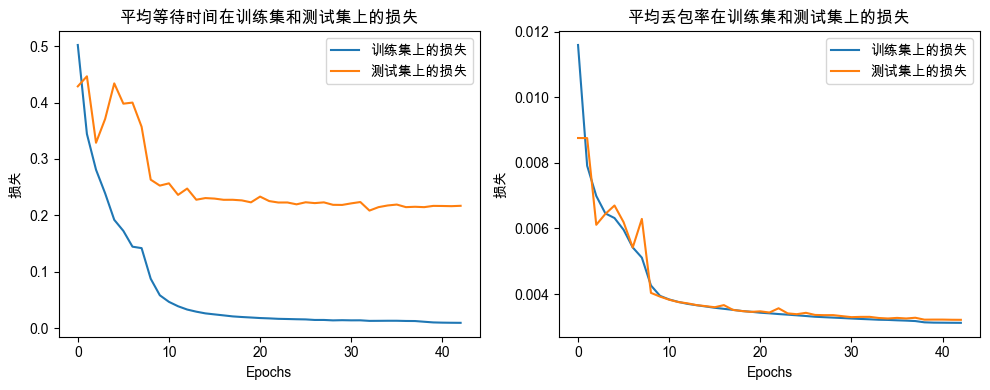

In [195]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    concatenate,
    Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units1 = 512  # DNN单元数量
hidden_units2 = 256  # DNN单元数量
hidden_units3 = 128  # DNN单元数量

# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 扁平化序列型数据
arrival_rate_flatten = Flatten()(arrival_rate_input)
CV_list_flatten = Flatten()(CV_list_input)
C_list_flatten = Flatten()(C_list_input)

# 合并所有输入
merged = concatenate([arrival_rate_flatten, CV_list_flatten, C_list_flatten, numeric_input])

# 定义 DNN 层
dnn_layer = Dense(hidden_units1, activation='relu')(merged)
dnn_layer = Dense(hidden_units2, activation='relu')(dnn_layer)
dnn_layer = Dense(hidden_units3, activation='relu')(dnn_layer)

# 输出层
wait_time_output = Dense(1, name="wait_time_output")(dnn_layer)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(dnn_layer)
queue_waiting_length_output = Dense(1, name="queue_waiting_length_output")(dnn_layer)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output, queue_waiting_length_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse"
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae"
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_3_1.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(history.history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(history.history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# # 绘制 queue_waiting_length_list 的训练损失和验证损失
# plt.subplot(1, 3, 3)
# plt.plot(
#     history.history["queue_waiting_length_output_loss"],
#     label="训练集上的损失",
# )
# plt.plot(
#     history.history["val_queue_waiting_length_output_loss"],
#     label="测试集上的损失",
# )
# plt.title("平均队列长度在训练集和测试集上的损失")
# plt.xlabel("Epochs")
# plt.ylabel("损失")
# plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/3.1.png", dpi=1200)
plt.show()

## 单隐藏层，64

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 CV_list (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list (InputLayer)         [(None, 20, 1)]              0         []                            
                                                                                                  
 flatten_27 (Flatten)        (None, 20)                   0         ['arrival_rate[0][0]']        
                                                                                           

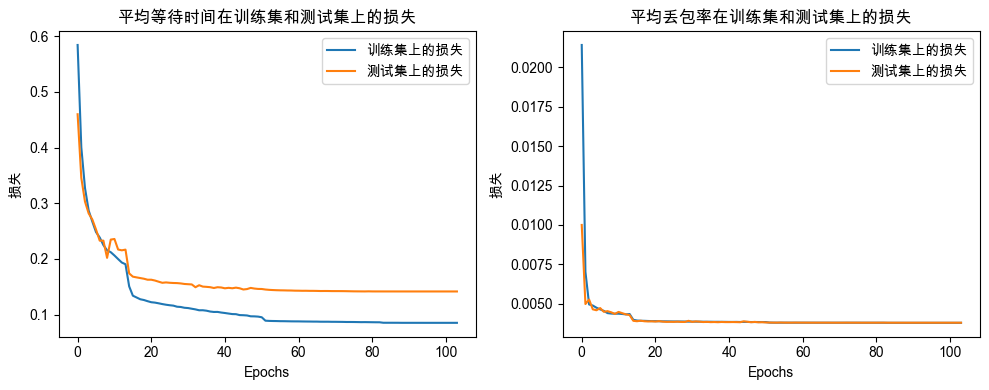

In [196]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    concatenate,
    Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64
# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 扁平化序列型数据
arrival_rate_flatten = Flatten()(arrival_rate_input)
CV_list_flatten = Flatten()(CV_list_input)
C_list_flatten = Flatten()(C_list_input)

# 合并所有输入
merged = concatenate([arrival_rate_flatten, CV_list_flatten, C_list_flatten, numeric_input])

# 定义 DNN 层
dnn_layer = Dense(hidden_units, activation='relu')(merged)

# 输出层
wait_time_output = Dense(1, name="wait_time_output")(dnn_layer)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(dnn_layer)
queue_waiting_length_output = Dense(1, name="queue_waiting_length_output")(dnn_layer)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output, queue_waiting_length_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse"
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae"
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_3_2.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(history.history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(history.history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# # 绘制 queue_waiting_length_list 的训练损失和验证损失
# plt.subplot(1, 3, 3)
# plt.plot(
#     history.history["queue_waiting_length_output_loss"],
#     label="训练集上的损失",
# )
# plt.plot(
#     history.history["val_queue_waiting_length_output_loss"],
#     label="测试集上的损失",
# )
# plt.title("平均队列长度在训练集和测试集上的损失")
# plt.xlabel("Epochs")
# plt.ylabel("损失")
# plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/3.2.png", dpi=1200)
plt.show()

--- 

# 尝试下加入多层DNN的基础RNN

### 4.1 Simple RNN（同时输出数值型变量和序列型变量）

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 numeric_input (InputLayer)  [(None, 8)]                  0         []                     

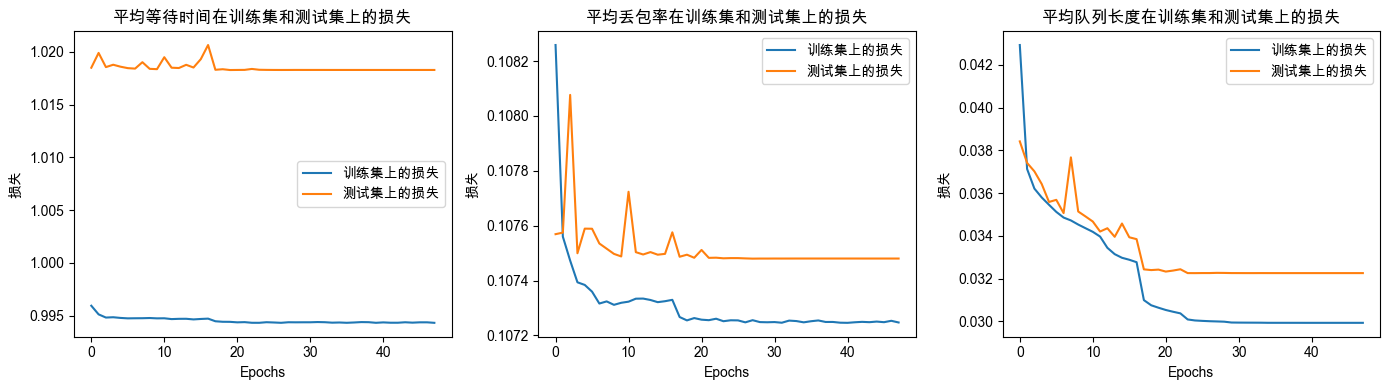

In [197]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    SimpleRNN,
    Dense,
    TimeDistributed,
    concatenate,
    Masking,
    RepeatVector,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
inputs = {}
for feature_name, feature_shape in zip(
    ["arrival_rate", "CV_list", "C_list"], [(sequence_input_length, 1)] * 3
):
    inputs[feature_name] = Input(shape=feature_shape, name=f"{feature_name}_input")
inputs["numeric_input"] = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# RNN层
rnn_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    rnn_layers[feature_name] = SimpleRNN(hidden_units, return_sequences=True)(
        input_layer
    )

# 扩展numeric_input的形状以匹配RNN层的输出形状
numeric_input_expanded = RepeatVector(sequence_input_length)(inputs["numeric_input"])

# ... 你之前的代码 ...

# 合并所有输入
merged = concatenate(list(rnn_layers.values()) + [numeric_input_expanded])

# 添加三个DNN隐藏层
dnn_layer = Dense(512, activation='relu')(merged)
dnn_layer = Dense(256, activation='relu')(dnn_layer)
dnn_layer = Dense(128, activation='relu')(dnn_layer)

# 定义输出层
outputs = {}
for output_name, output_shape in zip(
    ["wait_time_output", "pkg_loss_rate_output", "queue_waiting_length_output"],
    [(1,)] * 3,
):
    if output_name == "queue_waiting_length_output":
        outputs[output_name] = TimeDistributed(
            Dense(output_shape[-1]), name=output_name
        )(dnn_layer)
    else:
        outputs[output_name] = Dense(output_shape[-1], name=output_name)(dnn_layer)

# 填充训练集和测试集的序列型特征
max_sequence_length = max(df["n"])
X_train_padded_sequences = {}
X_test_padded_sequences = {}
for feature_name, feature_sequences in X_train_sequences.items():
    padded_sequences = pad_sequences(
        feature_sequences, maxlen=max_sequence_length, padding="post", dtype="float32"
    )
    X_train_padded_sequences[feature_name] = padded_sequences
    X_test_padded_sequences[feature_name] = pad_sequences(
        X_test_sequences[feature_name],
        maxlen=max_sequence_length,
        padding="post",
        dtype="float32",
    )

# 填充训练集和测试集的序列型目标变量
y_train_queue_padded = pad_sequences(
    y_train_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)
y_test_queue_padded = pad_sequences(
    y_test_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)

# 更新模型定义以包含Masking层
masked_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    masking_layer = Masking(mask_value=0.0)  # 假设填充值为0
    masked_layers[feature_name] = masking_layer(input_layer)

# RNN层
rnn_layers = {}
for feature_name, masked_layer in masked_layers.items():
    rnn_layers[feature_name] = SimpleRNN(hidden_units, return_sequences=True)(
        masked_layer
    )

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse",
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae",
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_4_1.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(history.history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 3, 2)
plt.plot(history.history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 queue_waiting_length_list 的训练损失和验证损失
plt.subplot(1, 3, 3)
plt.plot(
    history.history["queue_waiting_length_output_loss"],
    label="训练集上的损失",
)
plt.plot(
    history.history["val_queue_waiting_length_output_loss"],
    label="测试集上的损失",
)
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/4.1.png", dpi=1200)
plt.show()

### 4.2 Simple RNN（只考虑输出数值型变量）

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_78 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

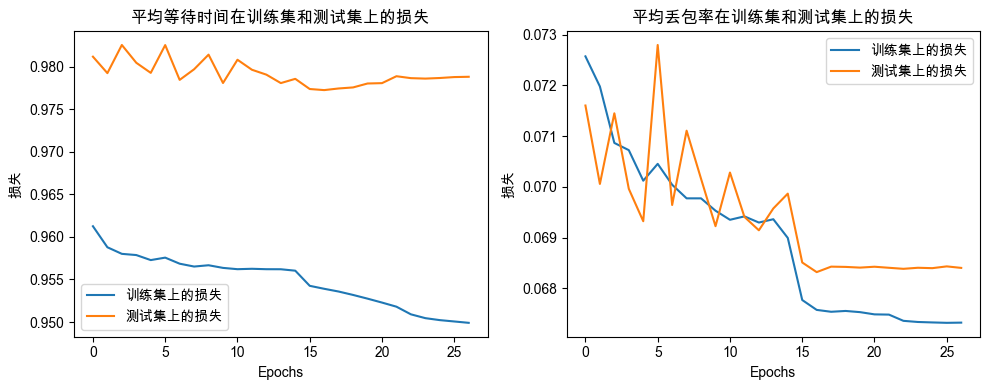

In [198]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list_input")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN
encoder_rnn = SimpleRNN(hidden_units, return_sequences=False, return_state=True)
encoder_outputs, state_h = encoder_rnn(
    concatenate([arrival_rate_input, CV_list_input, C_list_input])
)

# 新增的DNN隐藏层
hidden_layer_1 = Dense(512, activation='relu')(state_h)
hidden_layer_2 = Dense(256, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(128, activation='relu')(hidden_layer_2)

# 数值型输出层
wait_time_output = Dense(1, name="wait_time_output")(hidden_layer_3)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(hidden_layer_3)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={"wait_time_output": "mse", "pkg_loss_rate_output": "mse"},
    metrics={"wait_time_output": "mae", "pkg_loss_rate_output": "mae"},
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_4_2.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 解包 eval_results
total_loss, wait_time_loss, pkg_loss_rate_loss, wait_time_mae, pkg_loss_rate_mae = (
    eval_results
)

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_wait_time_output_loss"], label="测试集上的损失"
)
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(
    history.history["pkg_loss_rate_output_loss"], label="训练集上的损失"
)
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/4.2.png", dpi=1200)
plt.show()

### 4.3 Seq2Seq - Simple RNN（只考虑序列型变量，即waiting_length）

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_79 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

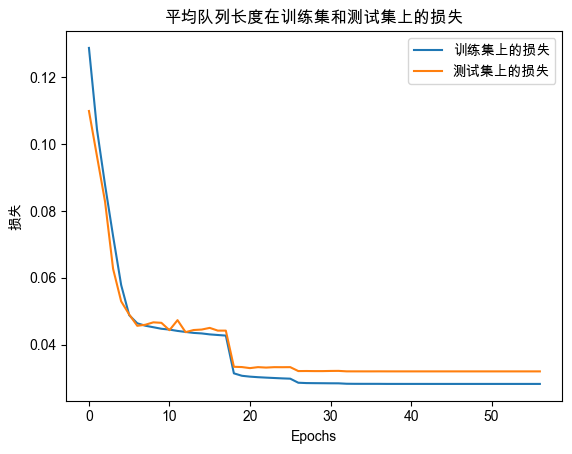

In [199]:
from tensorflow.keras.layers import (
    Input,
    SimpleRNN,
    Dense,
    RepeatVector,
    TimeDistributed,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
# 序列型输入
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")

# 数值型和分类型输入
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器
# 可以选择将所有序列型输入合并，或者只选择一个作为主要序列输入
encoder_inputs = concatenate([arrival_rate_input, CV_list_input, C_list_input])
encoder_rnn = SimpleRNN(hidden_units, return_state=True)
encoder_outputs, state_h = encoder_rnn(encoder_inputs)

# 解码器
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)

# 将数值型和分类型输入与解码器输出合并
decoder_outputs = concatenate(
    [decoder_outputs, RepeatVector(max_sequence_length)(numeric_input)]
)

# 在这里添加三个DNN隐藏层
dnn_hidden_layer_1 = TimeDistributed(Dense(512, activation='relu'))(decoder_outputs)
dnn_hidden_layer_2 = TimeDistributed(Dense(256, activation='relu'))(dnn_hidden_layer_1)
dnn_hidden_layer_3 = TimeDistributed(Dense(128, activation='relu'))(dnn_hidden_layer_2)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(dnn_hidden_layer_3)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_4_3.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/4.3.png", dpi=1200)
plt.show()

### 4.4 Seq2Seq - Simple RNN + 注意力机制（BA）（只考虑序列型变量，即waiting_length）

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_81 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

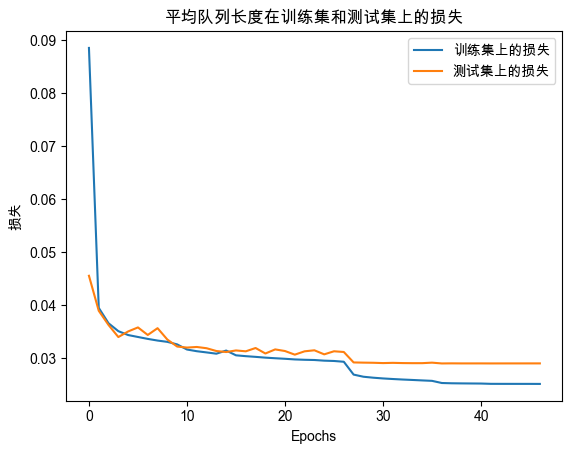

In [200]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, RepeatVector, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN，返回整个序列
encoder_rnn = SimpleRNN(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder_rnn(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 RNN，返回整个序列
decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)

# 注意力机制
attention = Attention()
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 输出层
decoder_dense = TimeDistributed(Dense(1))  # 假设输出是单变量序列
decoder_outputs = decoder_dense(decoder_combined_context)

# 将数值型和分类型输入与解码器输出合并
decoder_combined_context = concatenate(
    [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
)

# 添加三个DNN隐藏层
dnn_hidden_layer_1 = TimeDistributed(Dense(512, activation='relu'))(decoder_combined_context)
dnn_hidden_layer_2 = TimeDistributed(Dense(256, activation='relu'))(dnn_hidden_layer_1)
dnn_hidden_layer_3 = TimeDistributed(Dense(128, activation='relu'))(dnn_hidden_layer_2)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(dnn_hidden_layer_3)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_4_4.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/4.4.png", dpi=1200)
plt.show()

### 4.5 Seq2Seq - Simple RNN + 注意力机制（LA）（只考虑序列型变量，即waiting_length）

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_85 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

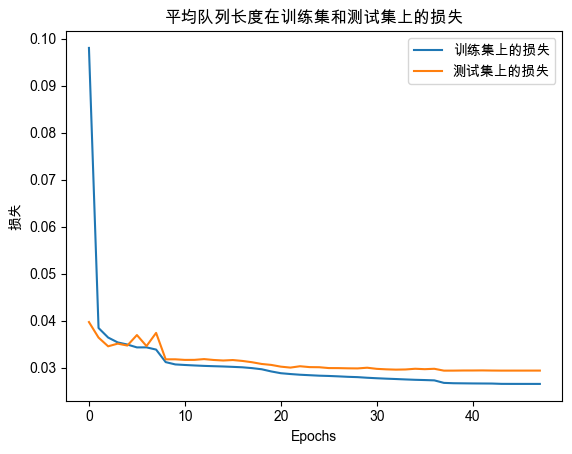

In [202]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, RepeatVector, TimeDistributed, Attention, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 RNN，返回整个序列
encoder_rnn = SimpleRNN(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder_rnn(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 RNN，返回整个序列
decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)

# Luong 注意力机制
attention = Attention(use_scale=True)
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 输出层
decoder_dense = TimeDistributed(Dense(1))  # 假设输出是单变量序列
decoder_outputs = decoder_dense(decoder_combined_context)

# 将数值型和分类型输入与解码器输出合并
decoder_combined_context = concatenate(
    [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
)

# 添加三个DNN隐藏层
dnn_hidden_layer_1 = TimeDistributed(Dense(512, activation='relu'))(decoder_combined_context)
dnn_hidden_layer_2 = TimeDistributed(Dense(256, activation='relu'))(dnn_hidden_layer_1)
dnn_hidden_layer_3 = TimeDistributed(Dense(128, activation='relu'))(dnn_hidden_layer_2)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(dnn_hidden_layer_3)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_4_5.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/4.5.png", dpi=1200)
plt.show()

### 5.1 LSTM（同时输出数值型变量和序列型变量）

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 masking_24 (Masking)        (None, 20, 1)                0         ['arrival_rate_input[0]

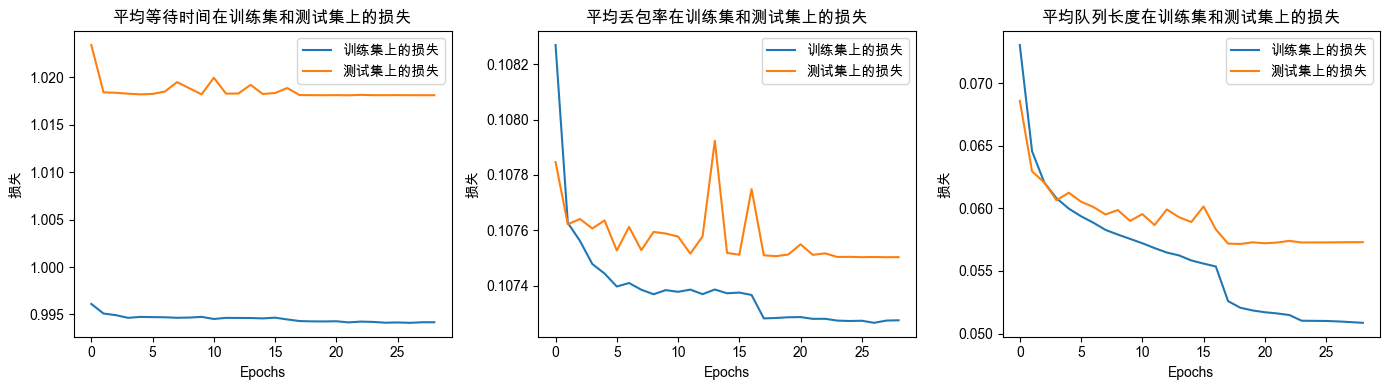

In [201]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    TimeDistributed,
    concatenate,
    Masking,
    RepeatVector,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # RNN单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
inputs = {}
for feature_name, feature_shape in zip(
    ["arrival_rate", "CV_list", "C_list"], [(sequence_input_length, 1)] * 3
):
    inputs[feature_name] = Input(shape=feature_shape, name=f"{feature_name}_input")
inputs["numeric_input"] = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# Masking层
masked_layers = {}
for feature_name, input_layer in inputs.items():
    if feature_name == "numeric_input":
        continue
    masked_layers[feature_name] = Masking(mask_value=0.0)(input_layer)  # 假设填充值为0

# LSTM层
lstm_layers = {}
for feature_name, masked_layer in masked_layers.items():
    lstm_layers[feature_name] = LSTM(hidden_units, return_sequences=True)(masked_layer)

# 扩展numeric_input的形状以匹配LSTM层的输出形状
numeric_input_expanded = RepeatVector(sequence_input_length)(inputs["numeric_input"])

# 合并所有输入
merged = concatenate(list(lstm_layers.values()) + [numeric_input_expanded])

# 添加三个DNN隐藏层
dnn_layer = Dense(512, activation='relu')(merged)
dnn_layer = Dense(256, activation='relu')(dnn_layer)
dnn_layer = Dense(128, activation='relu')(dnn_layer)

# 定义输出层
outputs = {}
for output_name, output_shape in zip(
    ["wait_time_output", "pkg_loss_rate_output", "queue_waiting_length_output"],
    [(1,)] * 3,
):
    if output_name == "queue_waiting_length_output":
        outputs[output_name] = TimeDistributed(
            Dense(output_shape[-1]), name=output_name
        )(dnn_layer)  # 注意这里我们从dnn_layer获取输出
    else:
        outputs[output_name] = Dense(output_shape[-1], name=output_name)(dnn_layer)

# 填充训练集和测试集的序列型特征
max_sequence_length = max(df["n"])
X_train_padded_sequences = {}
X_test_padded_sequences = {}
for feature_name, feature_sequences in X_train_sequences.items():
    padded_sequences = pad_sequences(
        feature_sequences, maxlen=max_sequence_length, padding="post", dtype="float32"
    )
    X_train_padded_sequences[feature_name] = padded_sequences
    X_test_padded_sequences[feature_name] = pad_sequences(
        X_test_sequences[feature_name],
        maxlen=max_sequence_length,
        padding="post",
        dtype="float32",
    )

# 填充训练集和测试集的序列型目标变量
y_train_queue_padded = pad_sequences(
    y_train_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)
y_test_queue_padded = pad_sequences(
    y_test_queue, maxlen=max_sequence_length, padding="post", dtype="float32"
)

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(
    optimizer="adam",
    loss={
        "wait_time_output": "mse",
        "pkg_loss_rate_output": "mse",
        "queue_waiting_length_output": "mse",
    },
    metrics={
        "wait_time_output": "mae",
        "pkg_loss_rate_output": "mae",
        "queue_waiting_length_output": "mae",
    },
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_5_1.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

y_train_queue_padded = np.expand_dims(
    y_train_queue_padded, -1
)  # 在最后一个轴上增加一个维度
y_test_queue_padded = np.expand_dims(
    y_test_queue_padded, -1
)  # 在最后一个轴上增加一个维度

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(history.history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 3, 2)
plt.plot(history.history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 queue_waiting_length_list 的训练损失和验证损失
plt.subplot(1, 3, 3)
plt.plot(
    history.history["queue_waiting_length_output_loss"],
    label="训练集上的损失",
)
plt.plot(
    history.history["val_queue_waiting_length_output_loss"],
    label="测试集上的损失",
)
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/5.1.png", dpi=1200)
plt.show()

### 5.2 LSTM（只考虑输出数值型变量）

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_88 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

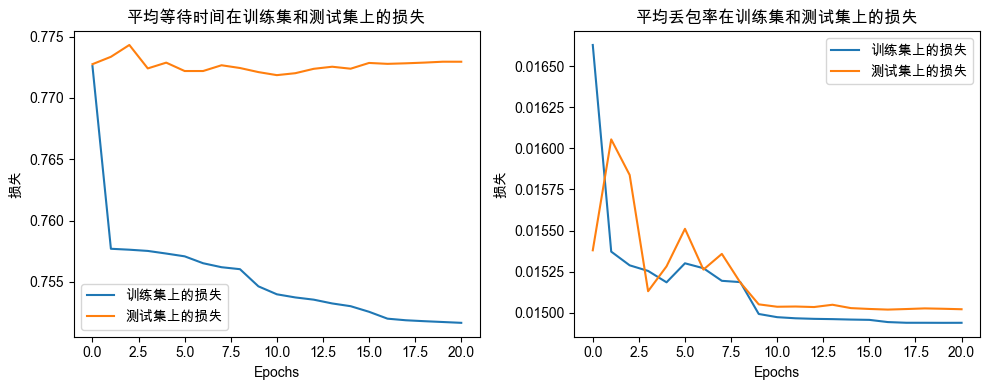

In [203]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
sequence_input_length = max(df["n"])  # 序列长度设置为最大值

# 定义输入层
arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list_input")
C_list_input = Input(shape=(sequence_input_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 LSTM
encoder_lstm = LSTM(hidden_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(
    concatenate([arrival_rate_input, CV_list_input, C_list_input])
)

# DNN隐藏层
dnn_hidden_1 = Dense(512, activation='relu')(state_h)
dnn_hidden_2 = Dense(256, activation='relu')(dnn_hidden_1)
dnn_hidden_3 = Dense(128, activation='relu')(dnn_hidden_2)

# 数值型特征与DNN输出合并
combined_features = concatenate([dnn_hidden_3, numeric_input])

# 数值型输出层
wait_time_output = Dense(1, name="wait_time_output")(combined_features)
pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(combined_features)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=[wait_time_output, pkg_loss_rate_output],
)

# 编译模型
model.compile(
    optimizer="adam",
    loss={"wait_time_output": "mse", "pkg_loss_rate_output": "mse"},
    metrics={"wait_time_output": "mae", "pkg_loss_rate_output": "mae"},
)

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_5_2.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 解包 eval_results
total_loss, wait_time_loss, pkg_loss_rate_loss, wait_time_mae, pkg_loss_rate_mae = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")

# 绘制 avg_wait_time 的训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["wait_time_output_loss"], label="训练集上的损失")
plt.plot(
    history.history["val_wait_time_output_loss"], label="测试集上的损失"
)
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

# 绘制 avg_pkg_loss_rate 的训练损失和验证损失
plt.subplot(1, 2, 2)
plt.plot(
    history.history["pkg_loss_rate_output_loss"], label="训练集上的损失"
)
plt.plot(
    history.history["val_pkg_loss_rate_output_loss"],
    label="测试集上的损失",
)
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/5.2.png", dpi=1200)
plt.show()

### 5.3 Seq2Seq - LSTM（只考虑序列型变量，即waiting_length）

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_90 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

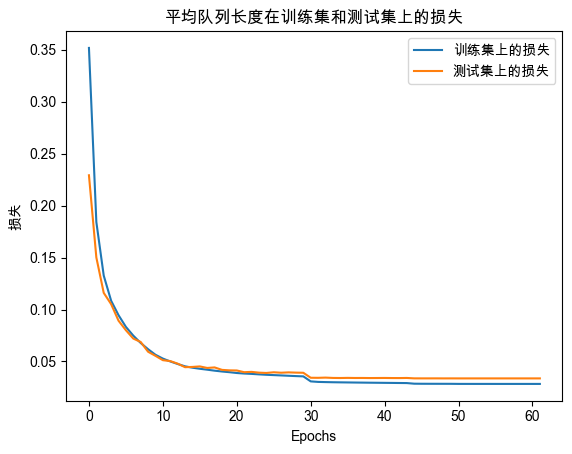

In [204]:
from tensorflow.keras.layers import (
    Input,
    LSTM,  # Import LSTM instead of SimpleRNN
    Dense,
    RepeatVector,
    TimeDistributed,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
# 序列型输入
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")

# 数值型和分类型输入
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器
# 可以选择将所有序列型输入合并，或者只选择一个作为主要序列输入
encoder_inputs = concatenate([arrival_rate_input, CV_list_input, C_list_input])
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(
    encoder_inputs
)  # LSTM returns cell state as well

# 解码器
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_lstm = LSTM(hidden_units, return_sequences=True)
decoder_outputs = decoder_lstm(
    decoder_inputs, initial_state=[state_h, state_c]
)  # LSTM requires both states

# 将数值型和分类型输入与解码器输出合并
decoder_outputs = concatenate(
    [decoder_outputs, RepeatVector(max_sequence_length)(numeric_input)]
)

# DNN隐藏层
dnn_hidden_1 = TimeDistributed(Dense(512, activation='relu'))(decoder_outputs)
dnn_hidden_2 = TimeDistributed(Dense(256, activation='relu'))(dnn_hidden_1)
dnn_hidden_3 = TimeDistributed(Dense(128, activation='relu'))(dnn_hidden_2)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(dnn_hidden_3)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_5_3.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/5.3.png", dpi=1200)
plt.show()

### 5.4 Seq2Seq - LSTM + 注意力机制（BA）（只考虑序列型变量，即waiting_length）

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_99 (Concatenat  (None, 20, 3)                0         ['arrival_rate_input[0]

W0000 00:00:1707892479.288912       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6258/6259 [============================>.] - ETA: 0s - loss: 0.3364

W0000 00:00:1707892550.210896       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.17380, saving model to best_model_5_4.h5
6259/6259 [==============================] - 77s 12ms/step - loss: 0.3364 - val_loss: 0.1738 - lr: 0.0010
Epoch 2/200
6259/6259 [==============================] - ETA: 0s - loss: 0.1627
Epoch 2: val_loss improved from 0.17380 to 0.15890, saving model to best_model_5_4.h5
6259/6259 [==============================] - 77s 12ms/step - loss: 0.1627 - val_loss: 0.1589 - lr: 0.0010
Epoch 3/200
6255/6259 [============================>.] - ETA: 0s - loss: 0.1566
Epoch 3: val_loss improved from 0.15890 to 0.15530, saving model to best_model_5_4.h5
6259/6259 [==============================] - 77s 12ms/step - loss: 0.1566 - val_loss: 0.1553 - lr: 0.0010
Epoch 4/200
6255/6259 [============================>.] - ETA: 0s - loss: 0.1541
Epoch 4: val_loss improved from 0.15530 to 0.15375, saving model to best_model_5_4.h5
6259/6259 [==============================] - 76s 12ms/step - loss: 0.1541 - val_loss: 0.1538 - lr: 0.

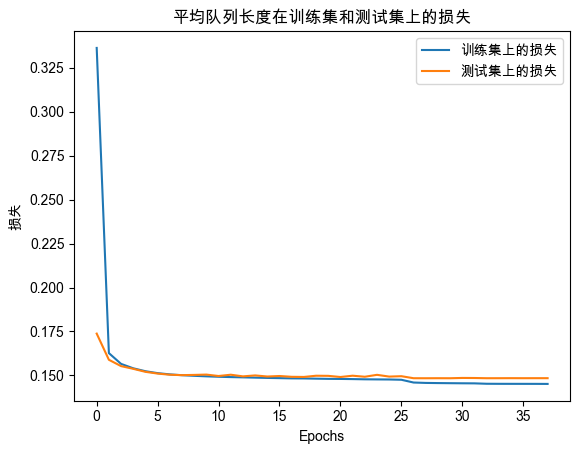

In [236]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 LSTM，返回整个序列和最后一个时间步的隐藏状态和单元状态
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 LSTM，返回整个序列
decoder_lstm = LSTM(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# 注意力机制
attention = Attention()
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 注意力机制和解码器输出的合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# DNN隐藏层
dnn_hidden_layer1 = Dense(512, activation='relu')(decoder_combined_context)
dnn_hidden_layer2 = Dense(256, activation='relu')(dnn_hidden_layer1)
dnn_hidden_layer3 = Dense(128, activation='relu')(dnn_hidden_layer2)

# 将数值型和分类型输入与DNN层的输出合并
decoder_numeric_combined = concatenate(
    [dnn_hidden_layer3, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(decoder_numeric_combined)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_5_4.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/5.4.png", dpi=1200)
plt.show()

### 5.5 Seq2Seq - LSTM + 注意力机制（LA）（只考虑序列型变量，即waiting_length）

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 arrival_rate_input (InputL  [(None, 20, 1)]              0         []                            
 ayer)                                                                                            
                                                                                                  
 CV_list_input (InputLayer)  [(None, 20, 1)]              0         []                            
                                                                                                  
 C_list_input (InputLayer)   [(None, 20, 1)]              0         []                            
                                                                                                  
 concatenate_102 (Concatena  (None, 20, 3)                0         ['arrival_rate_input[0]

W0000 00:00:1707897083.822469       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


6259/6259 [==============================] - ETA: 0s - loss: 0.3621

W0000 00:00:1707897214.355876       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.23826, saving model to best_model_5_5.h5
6259/6259 [==============================] - 145s 22ms/step - loss: 0.3621 - val_loss: 0.2383 - lr: 0.0010
Epoch 2/200
6258/6259 [============================>.] - ETA: 0s - loss: 0.1861
Epoch 2: val_loss improved from 0.23826 to 0.16622, saving model to best_model_5_5.h5
6259/6259 [==============================] - 142s 23ms/step - loss: 0.1861 - val_loss: 0.1662 - lr: 0.0010
Epoch 3/200
6257/6259 [============================>.] - ETA: 0s - loss: 0.1600
Epoch 3: val_loss improved from 0.16622 to 0.15709, saving model to best_model_5_5.h5
6259/6259 [==============================] - 141s 23ms/step - loss: 0.1600 - val_loss: 0.1571 - lr: 0.0010
Epoch 4/200
6258/6259 [============================>.] - ETA: 0s - loss: 0.1554
Epoch 4: val_loss improved from 0.15709 to 0.15537, saving model to best_model_5_5.h5
6259/6259 [==============================] - 144s 23ms/step - loss: 0.1554 - val_loss: 0.1554 - lr

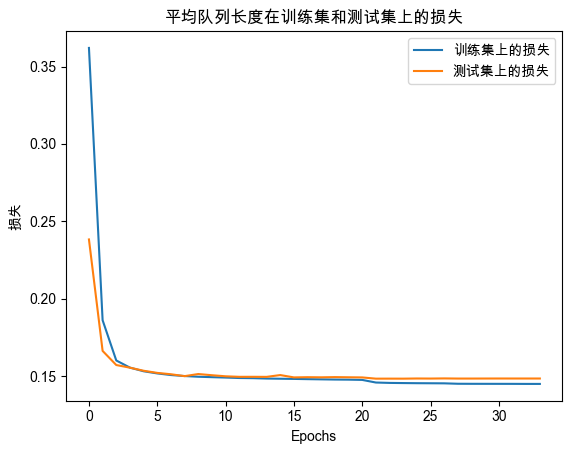

In [237]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Attention
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型参数
hidden_units = 64  # LSTM单元数量
max_sequence_length = max(df["n"])  # 所有序列的最大长度

# 定义输入层
arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

# 编码器 LSTM，返回整个序列和最后一个时间步的隐藏状态和单元状态
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(concatenate([arrival_rate_input, CV_list_input, C_list_input]))

# 解码器 LSTM，返回整个序列
decoder_lstm = LSTM(hidden_units, return_sequences=True)
decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Luong 注意力机制
attention = Attention(use_scale=True)
attention_outputs = attention([decoder_outputs, encoder_outputs])

# 将注意力输出与解码器输出合并
decoder_combined_context = concatenate([decoder_outputs, attention_outputs])

# 添加三个DNN隐藏层
dnn_hidden_1 = Dense(512, activation='relu')(decoder_combined_context)
dnn_hidden_2 = Dense(256, activation='relu')(dnn_hidden_1)
dnn_hidden_3 = Dense(128, activation='relu')(dnn_hidden_2)

# 将数值型和分类型输入与DNN层输出合并
combined_input = concatenate(
    [dnn_hidden_3, RepeatVector(max_sequence_length)(numeric_input)]
)

# 输出层
# 预测队列等待长度序列
queue_waiting_length_output = TimeDistributed(
    Dense(1), name="queue_waiting_length_output"
)(combined_input)

# 构建模型
model = Model(
    inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
    outputs=queue_waiting_length_output,
)

# 编译模型
model.compile(optimizer="adam", loss="mse")

# 模型摘要
model.summary()

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model_5_5.h5", monitor="val_loss", save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
]

# 训练模型时，我们需要使用填充后的序列和数值型特征
history = model.fit(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
)

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 在模型训练结束后，使用测试数据评估模型性能
total_loss = model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", total_loss)

# 打印损失
print(f"Total loss: {total_loss}")

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/5.5.png", dpi=1200)
plt.show()

---

## 计算标准化之前的MSE和MAE

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df = pd.read_excel('RR_simul_data.xlsx')

# 提取原始的数值型目标变量
y_train_original_values = df.loc[train_indices, ['avg_wait_time', 'avg_pkg_loss_rate']].values
y_test_original_values = df.loc[test_indices, ['avg_wait_time', 'avg_pkg_loss_rate']].values

# 提取原始的序列型目标变量
y_train_original_sequences = [eval(seq) for seq in df.loc[train_indices, 'queue_waiting_length_list']]
y_test_original_sequences = [eval(seq) for seq in df.loc[test_indices, 'queue_waiting_length_list']]

# 将数值型和序列型目标变量合并为一个列表，以便后续处理
y_train_original = [y_train_original_values, y_train_original_sequences]
y_test_original = [y_test_original_values, y_test_original_sequences]

# 初始化一个空的 DataFrame 来存储结果
results_df = pd.DataFrame(columns=["Model", "Train_MSE_Wait", "Train_MAE_Wait", "Test_MSE_Wait", "Test_MAE_Wait",
                                   "Train_MSE_Loss", "Train_MAE_Loss", "Test_MSE_Loss", "Test_MAE_Loss",
                                   "Train_MSE_Queue", "Train_MAE_Queue", "Test_MSE_Queue", "Test_MAE_Queue"])

# 模型输出配置
model_outputs_config = {
    # 'best_model_1_1.h5': ['wait_time_output', 'pkg_loss_rate_output', 'queue_waiting_length_output'],
    # 'best_model_1_2.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    # 'best_model_1_3.h5': ['queue_waiting_length_output'],
    # 'best_model_1_4.h5': ['queue_waiting_length_output'],
    # 'best_model_1_5.h5': ['queue_waiting_length_output'],
    # 'best_model_2_1.h5': ['wait_time_output', 'pkg_loss_rate_output', 'queue_waiting_length_output'],
    # 'best_model_2_2.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    # 'best_model_2_3.h5': ['queue_waiting_length_output'],
    # 'best_model_2_4.h5': ['queue_waiting_length_output'],
    # 'best_model_2_5.h5': ['queue_waiting_length_output'],
    # 'best_model_3_1.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    # 'best_model_3_2.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    # 'best_model_4_1.h5': ['wait_time_output', 'pkg_loss_rate_output', 'queue_waiting_length_output'],
    # 'best_model_4_2.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    # 'best_model_4_3.h5': ['queue_waiting_length_output'],
    # 'best_model_4_4.h5': ['queue_waiting_length_output'],
    # 'best_model_4_5.h5': ['queue_waiting_length_output'],
    # 'best_model_5_1.h5': ['wait_time_output', 'pkg_loss_rate_output', 'queue_waiting_length_output'],
    # 'best_model_5_2.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    # 'best_model_5_3.h5': ['queue_waiting_length_output'],
    # 'best_model_5_4.h5': ['queue_waiting_length_output'],
    # 'best_model_5_5.h5': ['queue_waiting_length_output']
    'best_model_6_1.h5': ['wait_time_output', 'pkg_loss_rate_output'],
    'best_model_6_2.h5': ['queue_waiting_length_output']
}

# 模型文件列表
model_files = list(model_outputs_config.keys())

# 遍历模型文件，加载模型，计算 MSE 和 MAE
for model_file in model_files:
    
    # 加载模型
    model = load_model(model_file)

    # 获取当前模型的输出配置
    outputs_config = model_outputs_config.get(model_file)
    
    # 创建一个字典来存储当前模型的结果
    model_results = {"Model": model_file}
    print(f'Model {model_file} has input keys:', [input_layer.name.split(':')[0] for input_layer in model.inputs])
    
    try:
        # 在训练集上进行预测
        y_train_pred = model.predict({
            "CV_list_input": X_train_padded_sequences["CV_list"],
            "C_list_input": X_train_padded_sequences["C_list"],
            "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
            "numeric_input": X_train_numeric
        })

        # 在测试集上进行预测
        y_test_pred = model.predict({
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "numeric_input": X_test_numeric
        })
    except:
        try:
            # 在训练集上进行预测
            y_train_pred = model.predict({
                "CV_list": X_train_padded_sequences["CV_list"],
                "C_list": X_train_padded_sequences["C_list"],
                "arrival_rate": X_train_padded_sequences["arrival_rate"],
                "numeric_input": X_train_numeric
            })

            # 在测试集上进行预测
            y_test_pred = model.predict({
                "CV_list": X_test_padded_sequences["CV_list"],
                "C_list": X_test_padded_sequences["C_list"],
                "arrival_rate": X_test_padded_sequences["arrival_rate"],
                "numeric_input": X_test_numeric
            })
        except Exception as e2:
            print(e2)

    # 定义一个函数来截断预测结果
    def truncate_predictions(predictions, original_sequences):
        truncated = []
        for i, original_seq in enumerate(original_sequences):
            # 截取每个预测结果的前 len(original_seq) 个元素
            truncated_seq = predictions[i, :len(original_seq), 0]  # 提取第 i 个样本的前 len(original_seq) 个预测值
            truncated.append(truncated_seq)
        return truncated
    
    # 根据模型的输出配置计算 MSE 和 MAE
    for output_name in outputs_config:
        if output_name == 'wait_time_output':
            # 反标准化预测结果
            try:
                y_train_pred_wait_time = scaler_time.inverse_transform(y_train_pred['wait_time_output'][:, -1, :])
                y_test_pred_wait_time = scaler_time.inverse_transform(y_test_pred['wait_time_output'][:, -1, :])
            except:
                try:
                    y_train_pred_wait_time = scaler_time.inverse_transform(y_train_pred[0])
                    y_test_pred_wait_time = scaler_time.inverse_transform(y_test_pred[0])
                except Exception as e2:
                    print(1)
                    print(e2)
            
            # 计算 MSE 和 MAE
            train_mse_wait = mean_squared_error(y_train_original_values[:, 0], y_train_pred_wait_time)
            train_mae_wait = mean_absolute_error(y_train_original_values[:, 0], y_train_pred_wait_time)
            test_mse_wait = mean_squared_error(y_test_original_values[:, 0], y_test_pred_wait_time)
            test_mae_wait = mean_absolute_error(y_test_original_values[:, 0], y_test_pred_wait_time)
            
            # 将结果添加到字典
            model_results.update({
                "Train_MSE_Wait": train_mse_wait,
                "Train_MAE_Wait": train_mae_wait,
                "Test_MSE_Wait": test_mse_wait,
                "Test_MAE_Wait": test_mae_wait
            })
        elif output_name == 'pkg_loss_rate_output':
            # 使用原始预测结果
            try:
                y_train_pred_pkg_loss_rate = y_train_pred['pkg_loss_rate_output']
                y_test_pred_pkg_loss_rate = y_test_pred['pkg_loss_rate_output']
            except:
                try:
                    y_train_pred_pkg_loss_rate = y_train_pred[1]
                    y_test_pred_pkg_loss_rate = y_test_pred[1]
                except Exception as e2:
                    print(2)
                    print(e2)
            
            # 计算 MSE 和 MAE
            try:
                train_mse_loss = mean_squared_error(y_train_original_values[:, 1], y_train_pred_pkg_loss_rate[:, -1, 0].flatten())
                train_mae_loss = mean_absolute_error(y_train_original_values[:, 1], y_train_pred_pkg_loss_rate[:, -1, 0].flatten())
                test_mse_loss = mean_squared_error(y_test_original_values[:, 1], y_test_pred_pkg_loss_rate[:, -1, 0].flatten())
                test_mae_loss = mean_absolute_error(y_test_original_values[:, 1], y_test_pred_pkg_loss_rate[:, -1, 0].flatten())
            except:
                try:
                    train_mse_loss = mean_squared_error(y_train_original_values[:, 1], y_train_pred_pkg_loss_rate.flatten())
                    train_mae_loss = mean_absolute_error(y_train_original_values[:, 1], y_train_pred_pkg_loss_rate.flatten())
                    test_mse_loss = mean_squared_error(y_test_original_values[:, 1], y_test_pred_pkg_loss_rate.flatten())
                    test_mae_loss = mean_absolute_error(y_test_original_values[:, 1], y_test_pred_pkg_loss_rate.flatten())
                except Exception as e2:
                    print(2.5)
                    print(e2)
            
            # 将结果添加到字典
            model_results.update({
                "Train_MSE_Loss": train_mse_loss,
                "Train_MAE_Loss": train_mae_loss,
                "Test_MSE_Loss": test_mse_loss,
                "Test_MAE_Loss": test_mae_loss
            })
        elif output_name == 'queue_waiting_length_output':
            try:
                # 截断训练集和测试集的预测结果
                y_train_pred_truncated = truncate_predictions(y_train_pred['queue_waiting_length_output'], y_train_original_sequences)
                y_test_pred_truncated = truncate_predictions(y_test_pred['queue_waiting_length_output'], y_test_original_sequences)
            except:
                try:
                    y_train_pred_truncated = truncate_predictions(y_train_pred, y_train_original_sequences)
                    y_test_pred_truncated = truncate_predictions(y_test_pred, y_test_original_sequences)
                except:
                    try:
                        y_train_pred_truncated = truncate_predictions(y_train_pred[2], y_train_original_sequences)
                        y_test_pred_truncated = truncate_predictions(y_test_pred[2], y_test_original_sequences)
                    except Exception as e2:
                        print(3)
                        print(e2)
                    
            # 定义一个函数来计算每个序列的均值和标准差
            def compute_mean_std_per_sample(sequences):
                means = [np.mean(seq) for seq in sequences]
                stds = [np.std(seq) for seq in sequences]
                return means, stds
            
            # 计算训练集和测试集序列的均值和标准差
            train_means, train_stds = compute_mean_std_per_sample(y_train_original_sequences)
            test_means, test_stds = compute_mean_std_per_sample(y_test_original_sequences)
            
            # 定义一个函数来反标准化每个预测序列
            def inverse_transform_per_sample(predictions, means, stds):
                unscaled_predictions = []
                for pred, mean, std in zip(predictions, means, stds):
                    # 反标准化序列
                    unscaled_seq = pred * std + mean
                    unscaled_predictions.append(unscaled_seq)
                return unscaled_predictions
            
            # 反标准化预测结果
            y_train_pred_unscaled = inverse_transform_per_sample(y_train_pred_truncated, train_means, train_stds)
            y_test_pred_unscaled = inverse_transform_per_sample(y_test_pred_truncated, test_means, test_stds)

            # 计算每个样本的MSE和MAE
            train_mse_queue = [np.mean((s1 - s2) ** 2) for s1, s2 in zip(y_train_original_sequences, y_train_pred_unscaled)]
            train_mae_queue = [np.mean(np.abs(s1 - s2)) for s1, s2 in zip(y_train_original_sequences, y_train_pred_unscaled)]
            test_mse_queue = [np.mean((s1 - s2) ** 2) for s1, s2 in zip(y_test_original_sequences, y_test_pred_unscaled)]
            test_mae_queue = [np.mean(np.abs(s1 - s2)) for s1, s2 in zip(y_test_original_sequences, y_test_pred_unscaled)]

            # 计算整体的MSE和MAE
            train_mse_queue = np.mean(train_mse_queue)
            train_mae_queue = np.mean(train_mae_queue)
            test_mse_queue = np.mean(test_mse_queue)
            test_mae_queue = np.mean(test_mae_queue)
            
            # 将结果添加到字典
            model_results.update({
                "Train_MSE_Queue": train_mse_queue,
                "Train_MAE_Queue": train_mae_queue,
                "Test_MSE_Queue": test_mse_queue,
                "Test_MAE_Queue": test_mae_queue
            })
        else:
            # 如果模型没有某种输出，填充 "N/A"
            model_results.update({
                f"Train_MSE_{output_name}": "N/A",
                f"Train_MAE_{output_name}": "N/A",
                f"Test_MSE_{output_name}": "N/A",
                f"Test_MAE_{output_name}": "N/A"
            })
    
    # 将当前模型的结果添加到 DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([model_results])], ignore_index=True)

# 显示结果
print(results_df)

Model best_model_6_1.h5 has input keys: ['arrival_rate', 'CV_list', 'C_list', 'numeric_input']
1565/1565 [==============================] - 1s 492us/step
Model best_model_6_2.h5 has input keys: ['arrival_rate_input', 'CV_list_input', 'C_list_input', 'numeric_input']
1565/1565 [==============================] - 9s 6ms/step
               Model  Train_MSE_Wait  Train_MAE_Wait  Test_MSE_Wait  \
0  best_model_6_1.h5   108732.768696      114.992276  316245.203249   
1  best_model_6_2.h5             NaN             NaN            NaN   

   Test_MAE_Wait  Train_MSE_Loss  Train_MAE_Loss  Test_MSE_Loss  \
0     136.977836        0.003349        0.039049       0.003359   
1            NaN             NaN             NaN            NaN   

   Test_MAE_Loss  Train_MSE_Queue  Train_MAE_Queue  Test_MSE_Queue  \
0       0.039106              NaN              NaN             NaN   
1            NaN         0.436168          0.29239        0.449613   

   Test_MAE_Queue  
0             NaN  
1        

In [245]:
results_df.to_excel('benchmark_model_perf_2.xlsx')

In [5]:
results_df

,Model,Train_MSE_Wait,Train_MAE_Wait,Test_MSE_Wait,Test_MAE_Wait,Train_MSE_Loss,Train_MAE_Loss,Test_MSE_Loss,Test_MAE_Loss,Train_MSE_Queue,Train_MAE_Queue,Test_MSE_Queue,Test_MAE_Queue
0,best_model_6_1.h5,108732.768696,114.992276,316245.203249,136.977836,0.003349,0.039049,0.003359,0.039106,NaN,NaN,NaN,NaN
1,best_model_6_2.h5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.436168,0.29239,0.449613,0.293922


In [225]:
y_train_original_values

array([[-0.44576073, -1.49171462],
       [-0.08035519,  0.40296992],
       [-0.1526977 , -0.08899967],
       ...,
       [-0.15357314, -0.56583444],
       [-0.44502999, -1.48058573],
       [-0.27574136, -0.64536416]])

---
# 一些凑数的图

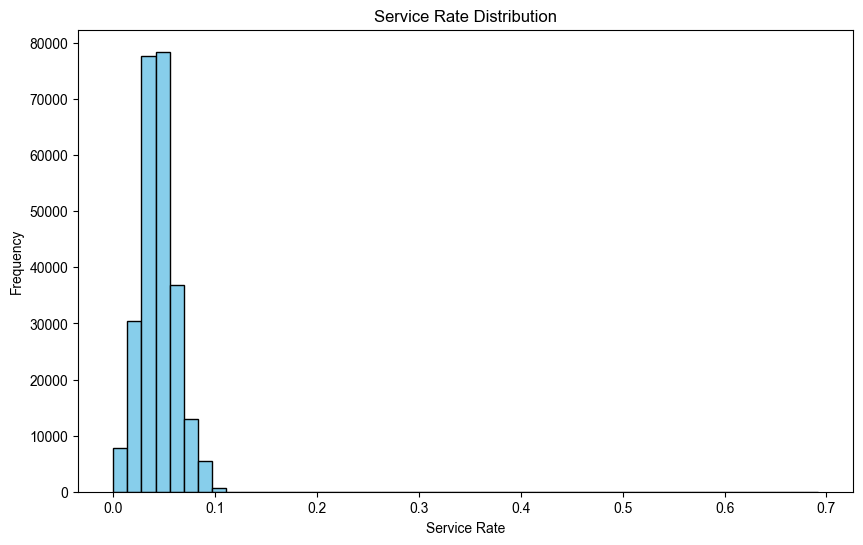

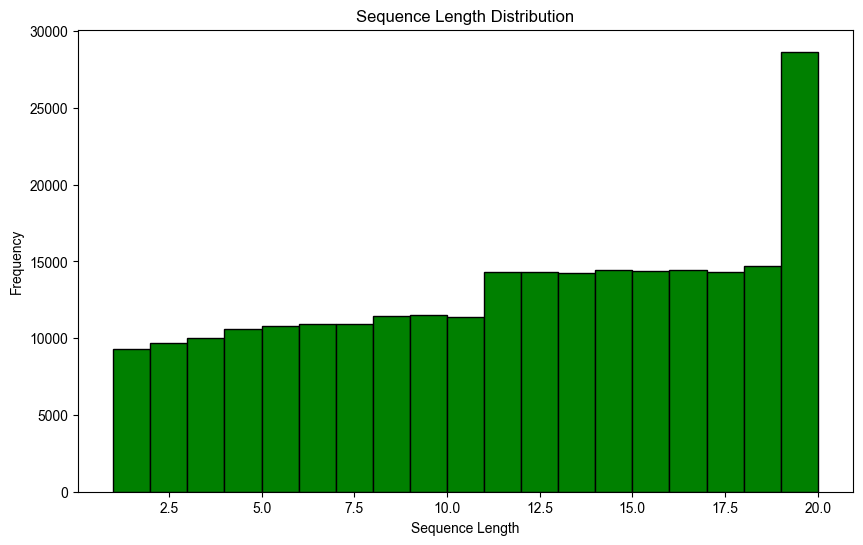

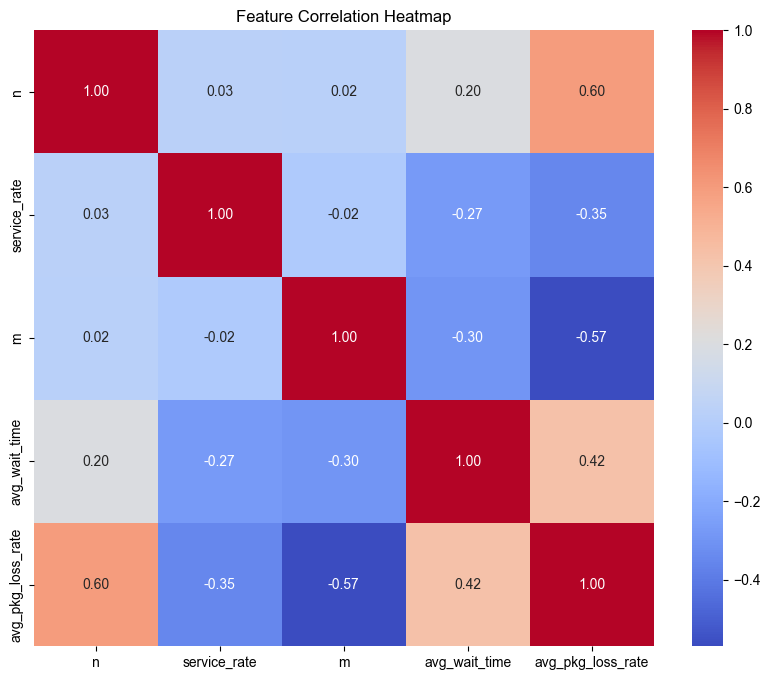

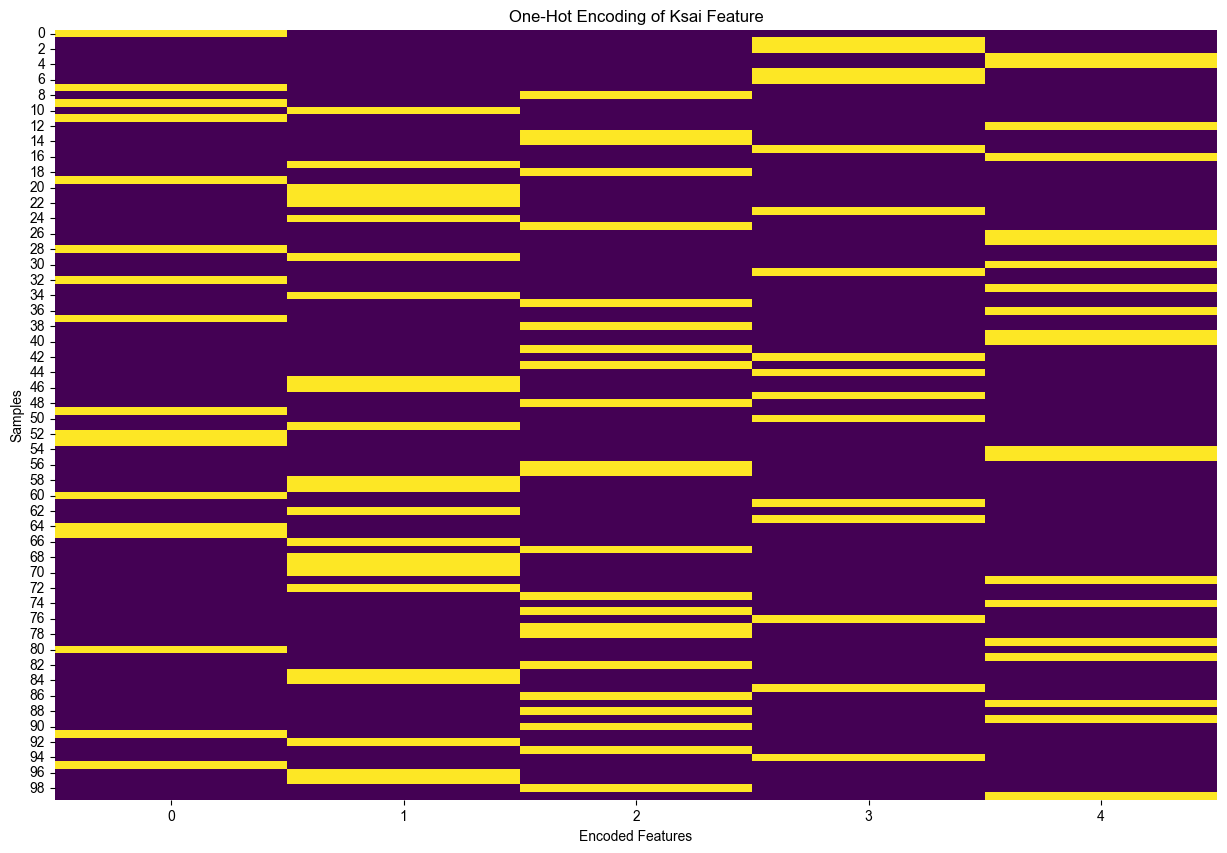

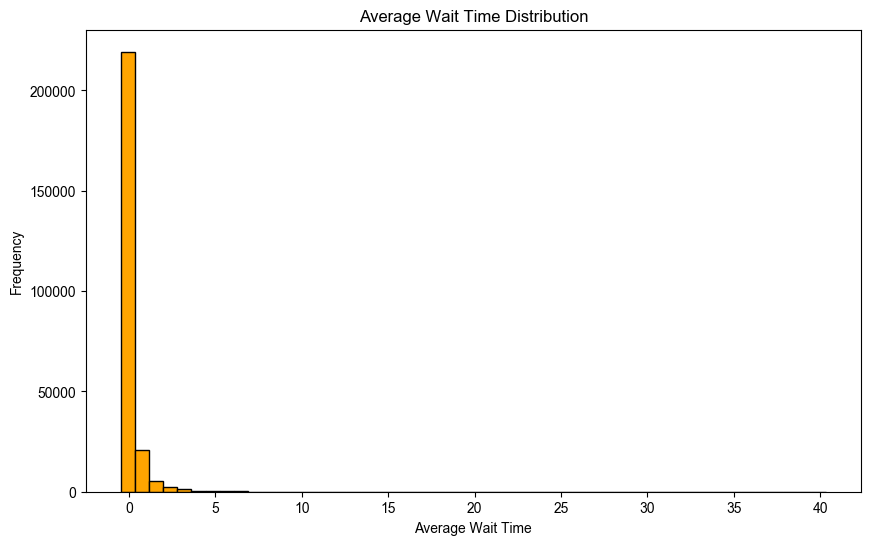

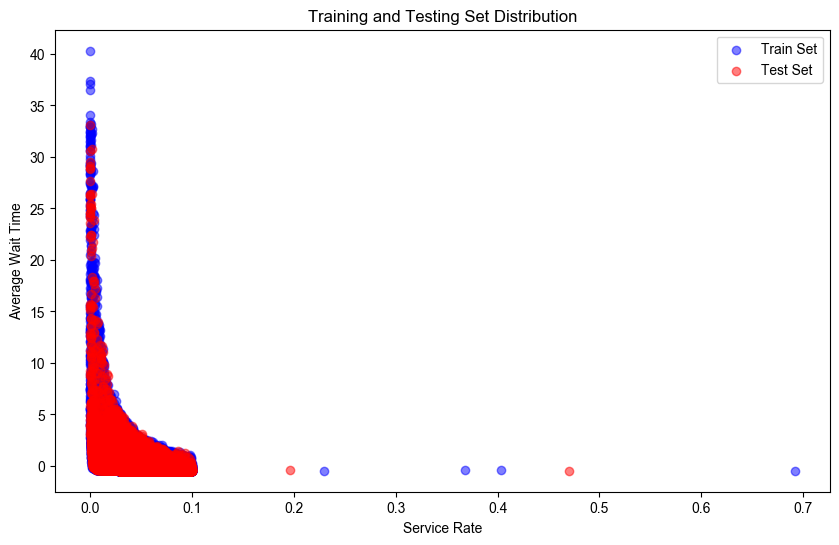

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.hist(df['service_rate'], bins=50, color='skyblue', edgecolor='black')
plt.title('Service Rate Distribution')
plt.xlabel('Service Rate')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['n'], bins=np.arange(df['n'].min(), df['n'].max() + 1), color='green', edgecolor='black')
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 8))
corr = df[['n', 'service_rate', 'm', 'avg_wait_time', 'avg_pkg_loss_rate']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# 假设 ksai_encoded 已经是独热编码后的 NumPy 数组
plt.figure(figsize=(15, 10))
sns.heatmap(ksai_encoded[:100], cmap='viridis', cbar=False)  # 展示前100个样本
plt.title('One-Hot Encoding of Ksai Feature')
plt.xlabel('Encoded Features')
plt.ylabel('Samples')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['avg_wait_time'], bins=50, color='orange', edgecolor='black')
plt.title('Average Wait Time Distribution')
plt.xlabel('Average Wait Time')
plt.ylabel('Frequency')
plt.show()

# 假设我们选择 'service_rate' 和 'avg_wait_time' 作为 x 轴和 y 轴
x_train = df.loc[train_indices, 'service_rate']
y_train = df.loc[train_indices, 'avg_wait_time']
x_test = df.loc[test_indices, 'service_rate']
y_test = df.loc[test_indices, 'avg_wait_time']

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, c='blue', alpha=0.5, label='Train Set')
plt.scatter(x_test, y_test, c='red', alpha=0.5, label='Test Set')
plt.legend()
plt.title('Training and Testing Set Distribution')
plt.xlabel('Service Rate')
plt.ylabel('Average Wait Time')
plt.show()

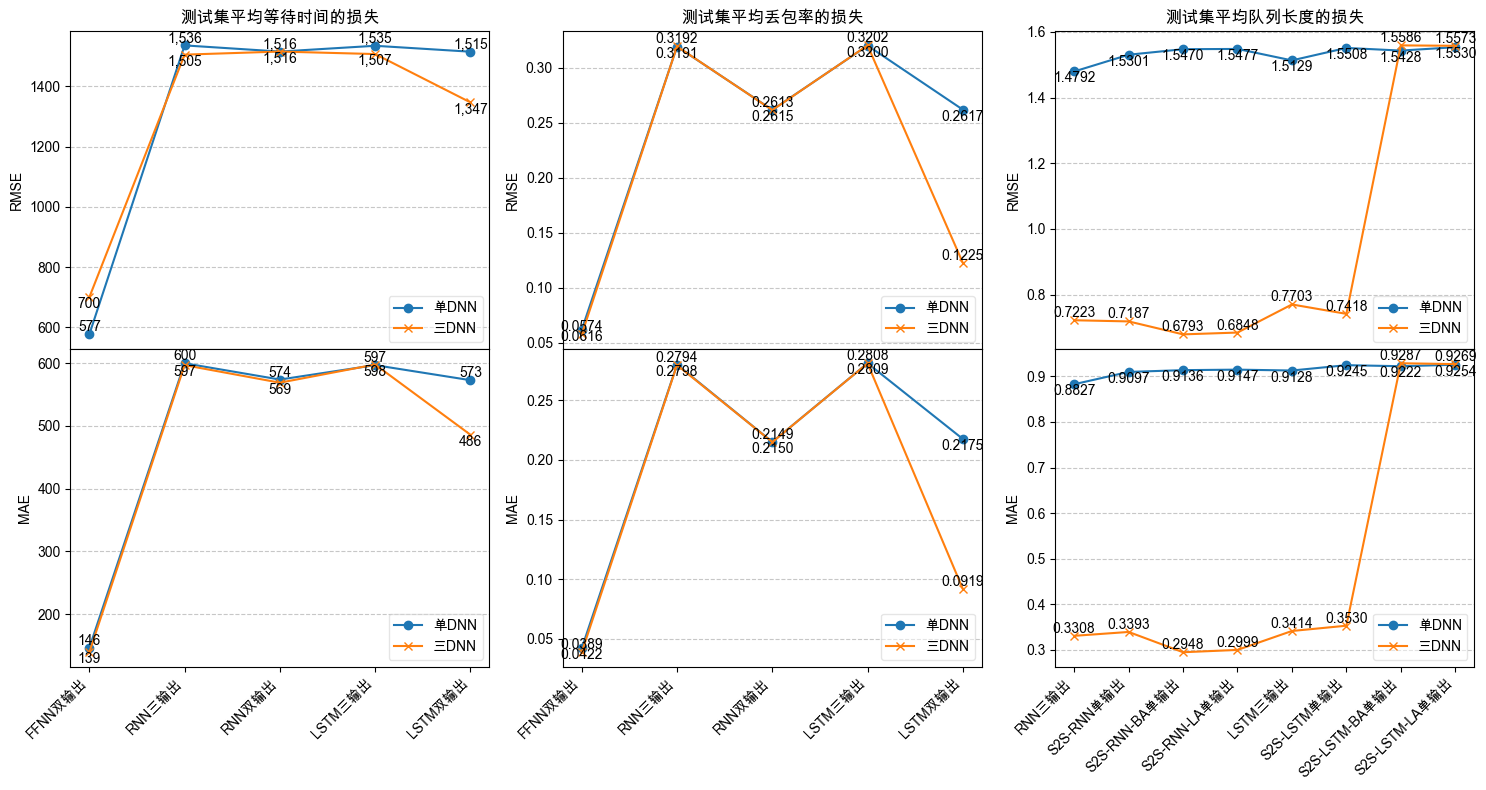

In [286]:
import matplotlib.pyplot as plt

# 数据录入
# 第一行的图形数据
models_wait = ['FFNN双输出', 'RNN三输出', 'RNN双输出', 'LSTM三输出', 'LSTM双输出']
test_mse_wait_single = [333068, 2359299, 2296752, 2355323, 2295397]
test_mse_wait_triple = [490403, 2265951, 2296881, 2271755, 1814170]
test_rmse_wait_single = [i**0.5 for i in test_mse_wait_single]
test_rmse_wait_triple = [i**0.5 for i in test_mse_wait_triple]
test_mae_wait_single = [146, 600, 574, 597, 573]
test_mae_wait_triple = [139, 597, 569, 598, 486]

# 第二行的图形数据
models_loss = ['FFNN双输出', 'RNN三输出', 'RNN双输出', 'LSTM三输出', 'LSTM双输出']
test_mse_loss_single = [0.0038, 0.1018, 0.0684, 0.1024, 0.0685]
test_mse_loss_triple = [0.0033, 0.1019, 0.0683, 0.1025, 0.0150]
test_rmse_loss_single = [i**0.5 for i in test_mse_loss_single]
test_rmse_loss_triple = [i**0.5 for i in test_mse_loss_triple]
test_mae_loss_single = [0.0422, 0.2798, 0.2150, 0.2809, 0.2175]
test_mae_loss_triple = [0.0389, 0.2794, 0.2149, 0.2808, 0.0919]

# 第三行的图形数据
models_queue = ['RNN三输出', 'S2S-RNN单输出', 'S2S-RNN-BA单输出', 'S2S-RNN-LA单输出', 'LSTM三输出', 'S2S-LSTM单输出', 'S2S-LSTM-BA单输出', 'S2S-LSTM-LA单输出']
test_mse_queue_single = [2.1880, 2.3412, 2.3932, 2.3955, 2.2888, 2.4050, 2.3802, 2.4118]
test_mse_queue_triple = [0.5217, 0.5166, 0.4615, 0.4690, 0.5934, 0.5502, 2.4291, 2.4252]
test_rmse_queue_single = [i**0.5 for i in test_mse_queue_single]
test_rmse_queue_triple = [i**0.5 for i in test_mse_queue_triple]
test_mae_queue_single = [0.8827, 0.9097, 0.9136, 0.9147, 0.9128, 0.9245, 0.9222, 0.9254]
test_mae_queue_triple = [0.3308, 0.3393, 0.2948, 0.2999, 0.3414, 0.3530, 0.9287, 0.9269]

# 数据已经被定义，绘制图形
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex='col', gridspec_kw={'hspace': 0})  # 2行3列的子图，同一列共享x轴，且垂直间距为0

# 第一行图形 - Wait MSE
x_wait = range(len(models_wait))
axs[0, 0].plot(x_wait, test_rmse_wait_single, 'o-', label='单DNN')
axs[0, 0].plot(x_wait, test_rmse_wait_triple, 'x-', label='三DNN')
axs[0, 0].set_title('测试集平均等待时间的损失')
axs[0, 0].set_ylabel('RMSE')
axs[0, 0].grid(True, linestyle='--', which='both', axis='y', alpha=0.7)
axs[0, 0].legend(loc='lower right', framealpha=0.5)

# 第一行图形 - Loss MSE
x_loss = range(len(models_loss))
axs[0, 1].plot(x_loss, test_rmse_loss_single, 'o-', label='单DNN')
axs[0, 1].plot(x_loss, test_rmse_loss_triple, 'x-', label='三DNN')
axs[0, 1].set_title('测试集平均丢包率的损失')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].grid(True, linestyle='--', which='both', axis='y', alpha=0.7)
axs[0, 1].legend(loc='lower right', framealpha=0.5)

# 第一行图形 - Queue MSE
x_queue = range(len(models_queue))
axs[0, 2].plot(x_queue, test_rmse_queue_single, 'o-', label='单DNN')
axs[0, 2].plot(x_queue, test_rmse_queue_triple, 'x-', label='三DNN')
axs[0, 2].set_title('测试集平均队列长度的损失')
axs[0, 2].set_ylabel('RMSE')
axs[0, 2].grid(True, linestyle='--', which='both', axis='y', alpha=0.7)
axs[0, 2].legend(loc='lower right', framealpha=0.5)

# 第二行图形 - Wait MAE
axs[1, 0].plot(x_wait, test_mae_wait_single, 'o-', label='单DNN')
axs[1, 0].plot(x_wait, test_mae_wait_triple, 'x-', label='三DNN')
# axs[1, 0].set_title('Test MAE Wait')
# axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].grid(True, linestyle='--', which='both', axis='y', alpha=0.7)
axs[1, 0].legend(loc='lower right', framealpha=0.5)

# 第二行图形 - Loss MAE
axs[1, 1].plot(x_loss, test_mae_loss_single, 'o-', label='单DNN')
axs[1, 1].plot(x_loss, test_mae_loss_triple, 'x-', label='三DNN')
# axs[1, 1].set_title('Test MAE Loss')
# axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].grid(True, linestyle='--', which='both', axis='y', alpha=0.7)
axs[1, 1].legend(loc='lower right', framealpha=0.5)

# 第二行图形 - Queue MAE
axs[1, 2].plot(x_queue, test_mae_queue_single, 'o-', label='单DNN')
axs[1, 2].plot(x_queue, test_mae_queue_triple, 'x-', label='三DNN')
# axs[1, 2].set_title('Test MAE Queue')
# axs[1, 2].set_xlabel('Model')
axs[1, 2].set_ylabel('MAE')
axs[1, 2].grid(True, linestyle='--', which='both', axis='y', alpha=0.7)
axs[1, 2].legend(loc='lower right', framealpha=0.5)

# 设置x轴标签
axs[1, 0].set_xticks(range(len(models_wait)))
axs[1, 0].set_xticklabels(models_wait, rotation=45, ha='right')
axs[1, 1].set_xticks(range(len(models_loss)))
axs[1, 1].set_xticklabels(models_loss, rotation=45, ha='right')
axs[1, 2].set_xticks(range(len(models_queue)))
axs[1, 2].set_xticklabels(models_queue, rotation=45, ha='right')

# 标记第一列图形的数据点
for i in x_wait:
    axs[0, 0].text(i, test_rmse_wait_single[i], f'{test_rmse_wait_single[i]:,.0f}', ha='center', va='bottom')
    axs[0, 0].text(i, test_rmse_wait_triple[i], f'{test_rmse_wait_triple[i]:,.0f}', ha='center', va='top')
    axs[1, 0].text(i, test_mae_wait_single[i], f'{test_mae_wait_single[i]:.0f}', ha='center', va='bottom')
    axs[1, 0].text(i, test_mae_wait_triple[i], f'{test_mae_wait_triple[i]:.0f}', ha='center', va='top')

# 标记第二列图形的数据点
for i in x_loss:
    axs[0, 1].text(i, test_rmse_loss_single[i], f'{test_rmse_loss_single[i]:.4f}', ha='center', va='top')
    axs[0, 1].text(i, test_rmse_loss_triple[i], f'{test_rmse_loss_triple[i]:.4f}', ha='center', va='bottom')
    axs[1, 1].text(i, test_mae_loss_single[i], f'{test_mae_loss_single[i]:.4f}', ha='center', va='top')
    axs[1, 1].text(i, test_mae_loss_triple[i], f'{test_mae_loss_triple[i]:.4f}', ha='center', va='bottom')

# 标记第三列图形的数据点
for i in x_queue:
    axs[0, 2].text(i, test_rmse_queue_single[i], f'{test_rmse_queue_single[i]:.4f}', ha='center', va='top')
    axs[0, 2].text(i, test_rmse_queue_triple[i], f'{test_rmse_queue_triple[i]:.4f}', ha='center', va='bottom')
    axs[1, 2].text(i, test_mae_queue_single[i], f'{test_mae_queue_single[i]:.4f}', ha='center', va='top')
    axs[1, 2].text(i, test_mae_queue_triple[i], f'{test_mae_queue_triple[i]:.4f}', ha='center', va='bottom')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0)

# 调整布局
plt.tight_layout()
plt.savefig("result.png", dpi=1200)
plt.show()

In [281]:
test_mse_wait_single = [333068, 2359299, 2296752, 2355323, 2295397]
test_mse_wait_triple = [490403, 2265951, 2296881, 2271755, 1814170]
test_rmse_wait_single = [i**0.5 for i in test_mse_wait_single]
test_rmse_wait_triple = [i**0.5 for i in test_mse_wait_triple]

---

# 最终章：网格搜索最优参数组合

## 数值型输出

Trial 10 Complete [00h 07m 06s]
val_loss: 0.7589136362075806

Best val_loss So Far: 0.7055166959762573
Total elapsed time: 01h 57m 36s
Best hyperparameters: {'units': 96, 'l2_rate': 1.325498100658928e-05}
1565/1565 [==============================] - 1s 367us/step - loss: 0.7055 - wait_time_output_loss: 0.1345 - pkg_loss_rate_output_loss: 0.0034 - queue_waiting_length_output_loss: 0.5618 - wait_time_output_mae: 0.0893 - pkg_loss_rate_output_mae: 0.0391 - queue_waiting_length_output_mae: 0.4786
Evaluation Results: [0.7055166959762573, 0.13454948365688324, 0.0033588327933102846, 0.5618446469306946, 0.08934678882360458, 0.0391058512032032, 0.4786281883716583]
Total loss: 0.7055166959762573
Avg wait time loss: 0.13454948365688324
Pkg loss rate loss: 0.0033588327933102846
Queue length loss: 0.5618446469306946
Avg wait time MAE: 0.08934678882360458
Pkg loss rate MAE: 0.0391058512032032
Queue length MAE: 0.4786281883716583


KeyError: 'wait_time_output_loss'

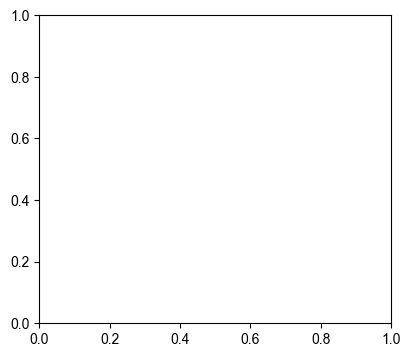

In [289]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    concatenate,
    Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch

warnings.filterwarnings("ignore")

# 定义模型构建函数
def build_model(hp):
    # 超参数
    hidden_units = hp.Int('units', min_value=32, max_value=512, step=32)
    l2_rate = hp.Float('l2_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')

    # 定义输入层
    arrival_rate_input = Input(shape=(sequence_input_length, 1), name="arrival_rate")
    CV_list_input = Input(shape=(sequence_input_length, 1), name="CV_list")
    C_list_input = Input(shape=(sequence_input_length, 1), name="C_list")
    numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")

    # 扁平化序列型数据
    arrival_rate_flatten = Flatten()(arrival_rate_input)
    CV_list_flatten = Flatten()(CV_list_input)
    C_list_flatten = Flatten()(C_list_input)

    # 合并所有输入
    merged = concatenate([arrival_rate_flatten, CV_list_flatten, C_list_flatten, numeric_input])

    # 定义 DNN 层
    dnn_layer = Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate))(merged)

    # 输出层
    wait_time_output = Dense(1, name="wait_time_output")(dnn_layer)
    pkg_loss_rate_output = Dense(1, name="pkg_loss_rate_output")(dnn_layer)
    queue_waiting_length_output = Dense(1, name="queue_waiting_length_output")(dnn_layer)

    # 构建模型
    model = Model(
        inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
        outputs=[wait_time_output, pkg_loss_rate_output, queue_waiting_length_output],
    )

    # 编译模型
    model.compile(
        optimizer="adam",
        loss={
            "wait_time_output": "mse",
            "pkg_loss_rate_output": "mse",
            "queue_waiting_length_output": "mse"
        },
        metrics={
            "wait_time_output": "mae",
            "pkg_loss_rate_output": "mae",
            "queue_waiting_length_output": "mae"
        },
    )
    return model

# 创建随机搜索调优器
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

# 定义回调函数
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model_temp.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
]

# 搜索超参数
tuner.search(
    {
        "arrival_rate": X_train_padded_sequences["arrival_rate"],
        "CV_list": X_train_padded_sequences["CV_list"],
        "C_list": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_train_wait,
        "pkg_loss_rate_output": y_train_pkg_loss,
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate": X_test_padded_sequences["arrival_rate"],
            "CV_list": X_test_padded_sequences["CV_list"],
            "C_list": X_test_padded_sequences["C_list"],
                    "numeric_input": X_test_numeric,  # 数值型特征
        },
        {
            "wait_time_output": y_test_wait,
            "pkg_loss_rate_output": y_test_pkg_loss,
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,  # 你可以根据需要调整epochs的数量
    batch_size=32,  # 你可以根据需要调整batch_size的大小
    callbacks=callbacks,
    verbose=1
)

# 获取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model_6_1.h5')

# 打印最佳模型的超参数
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters.values}")

# 在模型训练结束后，使用测试数据评估模型性能
eval_results = best_model.evaluate(
    {
        "arrival_rate": X_test_padded_sequences["arrival_rate"],
        "CV_list": X_test_padded_sequences["CV_list"],
        "C_list": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,  # 数值型特征
    },
    {
        "wait_time_output": y_test_wait,
        "pkg_loss_rate_output": y_test_pkg_loss,
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

# 假设模型有三个输出和一个总损失，每个输出有一个损失和一个指标
(
    total_loss,
    wait_time_loss,
    pkg_loss_rate_loss,
    queue_length_loss,
    wait_time_mae,
    pkg_loss_rate_mae,
    queue_length_mae,
) = eval_results

# 打印损失和评价指标
print(f"Total loss: {total_loss}")
print(f"Avg wait time loss: {wait_time_loss}")
print(f"Pkg loss rate loss: {pkg_loss_rate_loss}")
print(f"Queue length loss: {queue_length_loss}")
print(f"Avg wait time MAE: {wait_time_mae}")
print(f"Pkg loss rate MAE: {pkg_loss_rate_mae}")
print(f"Queue length MAE: {queue_length_mae}")

# 可视化部分需要根据best_model的训练历史来绘制
# 由于best_model是从tuner中获取的，我们需要从tuner的历史中获取训练历史
# 这里假设我们已经有了best_model的训练历史
history = best_model.history.history

# 绘制训练损失和验证损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["wait_time_output"], label="训练集上的损失")
plt.plot(history["val_wait_time_output_loss"], label="测试集上的损失")
plt.title("平均等待时间在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["pkg_loss_rate_output_loss"], label="训练集上的损失")
plt.plot(history["val_pkg_loss_rate_output_loss"], label="测试集上的损失")
plt.title("平均丢包率在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()

plt.tight_layout()
plt.savefig("模型效果（新）/数值-final.png", dpi=1200)
plt.show()

In [291]:
best_model

## 序列型输出

In [4]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, RepeatVector, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# 定义模型构建函数
def build_model(hp):
    # 超参数
    hidden_units = hp.Int('hidden_units', min_value=32, max_value=128, step=32)
    l2_rate = hp.Float('l2_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    
    # 输入层
    arrival_rate_input = Input(shape=(max_sequence_length, 1), name="arrival_rate_input")
    CV_list_input = Input(shape=(max_sequence_length, 1), name="CV_list_input")
    C_list_input = Input(shape=(max_sequence_length, 1), name="C_list_input")
    numeric_input = Input(shape=(X_train_numeric.shape[1],), name="numeric_input")
    
    # 编码器 RNN，返回整个序列
    encoder_rnn = SimpleRNN(hidden_units, return_sequences=True, return_state=True)
    encoder_outputs, state_h = encoder_rnn(concatenate([arrival_rate_input, CV_list_input, C_list_input]))
    
    # 解码器 RNN，返回整个序列
    decoder_rnn = SimpleRNN(hidden_units, return_sequences=True)
    decoder_inputs = RepeatVector(max_sequence_length)(state_h)  # 使用编码器的最后隐藏状态
    decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)
    
    # 注意力机制
    attention = Attention()
    attention_outputs = attention([decoder_outputs, encoder_outputs])
    
    # 将注意力输出与解码器输出合并
    decoder_combined_context = concatenate([decoder_outputs, attention_outputs])
    
    # 将数值型和分类型输入与解码器输出合并
    decoder_combined_context = concatenate(
        [decoder_combined_context, RepeatVector(max_sequence_length)(numeric_input)]
    )
    
    # 添加三个DNN隐藏层
    dnn_hidden_layer_1 = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=l2(l2_rate)))(decoder_combined_context)
    dnn_hidden_layer_2 = TimeDistributed(Dense(256, activation='relu', kernel_regularizer=l2(l2_rate)))(dnn_hidden_layer_1)
    dnn_hidden_layer_3 = TimeDistributed(Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)))(dnn_hidden_layer_2)
    
    # 输出层
    queue_waiting_length_output = TimeDistributed(
        Dense(1, kernel_regularizer=l2(l2_rate)), name="queue_waiting_length_output"
    )(dnn_hidden_layer_3)
    
    # 构建模型
    model = Model(
        inputs=[arrival_rate_input, CV_list_input, C_list_input, numeric_input],
        outputs=queue_waiting_length_output,
    )
    
    # 编译模型
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    
    return model

# 创建RandomSearch tuner实例
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

# 定义回调函数
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model_6_2.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
]

# 开始超参数搜索
tuner.search(
    {
        "arrival_rate_input": X_train_padded_sequences["arrival_rate"],
        "CV_list_input": X_train_padded_sequences["CV_list"],
        "C_list_input": X_train_padded_sequences["C_list"],
        "numeric_input": X_train_numeric,
    },
    {
        "queue_waiting_length_output": y_train_queue_padded,
    },
    validation_data=(
        {
            "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
            "CV_list_input": X_test_padded_sequences["CV_list"],
            "C_list_input": X_test_padded_sequences["C_list"],
            "numeric_input": X_test_numeric,
        },
        {
            "queue_waiting_length_output": y_test_queue_padded,
        },
    ),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 获取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model_6_2.h5')
# 打印最佳模型的超参数
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hyperparameters.values}")

# 评估最佳模型
eval_results = best_model.evaluate(
    {
        "arrival_rate_input": X_test_padded_sequences["arrival_rate"],
        "CV_list_input": X_test_padded_sequences["CV_list"],
        "C_list_input": X_test_padded_sequences["C_list"],
        "numeric_input": X_test_numeric,
    },
    {
        "queue_waiting_length_output": y_test_queue_padded,
    },
    verbose=1,
)

# 打印评估结果
print("Evaluation Results:", eval_results)

history = best_model.history.history

# 绘制训练损失和验证损失
plt.plot(history.history["loss"], label="训练集上的损失")
plt.plot(history.history["val_loss"], label="测试集上的损失")
plt.title("平均队列长度在训练集和测试集上的损失")
plt.xlabel("Epochs")
plt.ylabel("损失")
plt.legend()
plt.savefig("模型效果（新）/序列-final.png", dpi=1200)
plt.show()

# 绘制训练损失和验证损失
plt.plot(tuner.results_summary(), label="超参数搜索结果")
plt.title("超参数搜索结果")
plt.xlabel("Trial")
plt.ylabel("Validation Loss")
plt.legend()
# plt.savefig("模型效果（新）/序列-final.png", dpi=1200)
plt.show()

Trial 10 Complete [02h 48m 09s]
val_loss: 0.09111150354146957

Best val_loss So Far: 0.030065646395087242
Total elapsed time: 22h 06m 02s
Best hyperparameters: {'hidden_units': 128, 'l2_rate': 1.3070484061107011e-05, 'learning_rate': 0.0006767358590353206}
1565/1565 [==============================] - 6s 4ms/step - loss: 0.0301
Evaluation Results: 0.030065646395087242


AttributeError: 'dict' object has no attribute 'history'